In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score
from pathlib import Path
from PIL import Image
import os
from torchsummary import summary
import datetime
from torchmetrics import JaccardIndex

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

In [5]:
import PIL
print(PIL.PILLOW_VERSION)


8.2.0


In [6]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [8]:
class SimpsonsDataset():
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomRotation(degrees=(-25, 25)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        else:
            transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
       # x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('/simpsons_dataset')
TEST_DIR = Path('/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2,stratify=train_val_labels)

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


20933


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

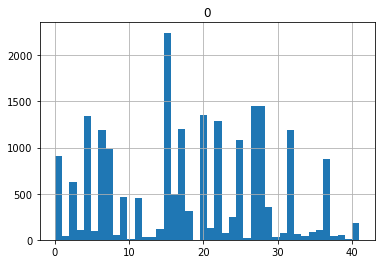

In [13]:
dataset = SimpsonsDataset(train_val_files, mode='train')
print(len(dataset))
logits = []
for x, y in dataset:
    logits.append(y)
logits = np.array(logits)
logits = pd.DataFrame(logits)
logits.hist(bins=42)

In [ ]:
logits.value_counts().to_frame()

In [14]:
train_dataset = SimpsonsDataset(train_val_files, mode='train')
print(len(train_dataset))
data_loader_train = DataLoader(train_dataset,shuffle=True, batch_size=256)
print(len(train_dataset), len(data_loader_train))

X, Y = iter(data_loader_train).next()
X, Y = X.to(device), Y.to(device)
print(X.shape, Y.shape)


20933
20933 82
torch.Size([256, 3, 224, 224]) torch.Size([256])


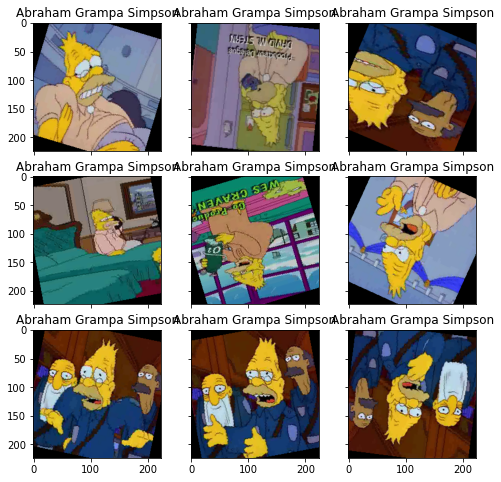

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                     sharey=True, sharex=True)
s = 0   
for fig_x in ax.flatten():
    random_characters = np.arange(10)
    im_val, label = train_dataset[random_characters[0+s]]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    s+=1

5-ти уровневая сверточная сеть со skip connection

In [7]:
class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()
        self.num_classes = n_classes
        self.Relu = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=8)
        self.contracting_11_res = self.shortcut_conv_block(in_channels=3, out_channels=8)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=8, out_channels=16)
        self.contracting_21_res = self.shortcut_conv_block(in_channels=8, out_channels=16)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=16, out_channels=32)
        self.contracting_31_res = self.shortcut_conv_block(in_channels=16, out_channels=32)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=32, out_channels=64)
        self.contracting_41_res = self.shortcut_conv_block(in_channels=32, out_channels=64)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_51 = self.conv_block(in_channels=64, out_channels=96)
        self.contracting_51_res = self.shortcut_conv_block(in_channels=64, out_channels=96)
        self.contracting_52 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Linear_01 = nn.Linear(96 * 7 * 7, 1024)
        self.output = nn.Linear(1024, n_classes)
        
        
    def shortcut_conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
                           nn.BatchNorm2d(num_features=out_channels))    
        return block
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_11_out_res = self.Relu(torch.add(self.contracting_11_res(X), contracting_11_out))
        contracting_12_out = self.contracting_12(contracting_11_out_res) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_21_out_res = self.Relu(torch.add(self.contracting_21_res(contracting_12_out), contracting_21_out))
        contracting_22_out = self.contracting_22(contracting_21_out_res) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_31_out_res = self.Relu(torch.add(self.contracting_31_res(contracting_22_out), contracting_31_out))
        contracting_32_out = self.contracting_32(contracting_31_out_res) # [-1, 256, 32, 32]
        
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 256, 64, 64]
        contracting_41_out_res = self.Relu(torch.add(self.contracting_41_res(contracting_32_out), contracting_41_out))
        contracting_42_out = self.contracting_42(contracting_41_out_res) 
        
        contracting_51_out = self.contracting_51(contracting_42_out) # [-1, 256, 64, 64]
        contracting_51_out_res = self.Relu(torch.add(self.contracting_51_res(contracting_42_out), contracting_51_out))
        contracting_52_out = self.contracting_52(contracting_51_out_res) 
        
        Linear_01_out = self.Linear_01(contracting_52_out.view(contracting_52_out.size(0), -1))
        output_out = self.output(Linear_01_out) # [-1, num_classes, 256, 256]

        return output_out

In [17]:
model = Model(42).to(device)
from torchsummary import summary
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 224, 224]         --
|    └─Conv2d: 2-1                       [-1, 8, 224, 224]         224
|    └─ReLU: 2-2                         [-1, 8, 224, 224]         --
|    └─BatchNorm2d: 2-3                  [-1, 8, 224, 224]         16
|    └─Conv2d: 2-4                       [-1, 8, 224, 224]         584
|    └─BatchNorm2d: 2-5                  [-1, 8, 224, 224]         16
├─Sequential: 1-2                        [-1, 8, 224, 224]         --
|    └─Conv2d: 2-6                       [-1, 8, 224, 224]         32
|    └─BatchNorm2d: 2-7                  [-1, 8, 224, 224]         16
├─ReLU: 1-3                              [-1, 8, 224, 224]         --
├─MaxPool2d: 1-4                         [-1, 8, 112, 112]         --
├─Sequential: 1-5                        [-1, 16, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 16, 112, 112]        1,168
|    └─ReL

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 224, 224]         --
|    └─Conv2d: 2-1                       [-1, 8, 224, 224]         224
|    └─ReLU: 2-2                         [-1, 8, 224, 224]         --
|    └─BatchNorm2d: 2-3                  [-1, 8, 224, 224]         16
|    └─Conv2d: 2-4                       [-1, 8, 224, 224]         584
|    └─BatchNorm2d: 2-5                  [-1, 8, 224, 224]         16
├─Sequential: 1-2                        [-1, 8, 224, 224]         --
|    └─Conv2d: 2-6                       [-1, 8, 224, 224]         32
|    └─BatchNorm2d: 2-7                  [-1, 8, 224, 224]         16
├─ReLU: 1-3                              [-1, 8, 224, 224]         --
├─MaxPool2d: 1-4                         [-1, 8, 112, 112]         --
├─Sequential: 1-5                        [-1, 16, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 16, 112, 112]        1,168
|    └─ReL

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
LR = 0.0001
model = Model(42).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
epochs = 200
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [19]:
val_dataset = SimpsonsDataset(val_files, mode='val')
print(len(val_dataset))
data_loader_val = DataLoader(val_dataset, batch_size=256)

4187


Используем отжиг градиента и сохранение чекпоинтов, чтобы автоматизировать процесс. Данная модель обучалась без аугументации, без кокой либо борьбы с несбалансированностью данных. Однако показала качесво 0,958 на кагле

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(3.7692, grad_fn=<NllLossBackward0>)
tensor(3.6149, grad_fn=<NllLossBackward0>)
tensor(3.6341, grad_fn=<NllLossBackward0>)
tensor(3.2659, grad_fn=<NllLossBackward0>)
tensor(3.6010, grad_fn=<NllLossBackward0>)
tensor(3.4082, grad_fn=<NllLossBackward0>)
tensor(3.4113, grad_fn=<NllLossBackward0>)
tensor(3.4354, grad_fn=<NllLossBackward0>)
tensor(3.0047, grad_fn=<NllLossBackward0>)
tensor(2.9178, grad_fn=<NllLossBackward0>)
tensor(3.0594, grad_fn=<NllLossBackward0>)
tensor(3.0759, grad_fn=<NllLossBackward0>)
tensor(2.8720, grad_fn=<NllLossBackward0>)
tensor(2.9239, grad_fn=<NllLossBackward0>)
tensor(3.0861, grad_fn=<NllLossBackward0>)
tensor(2.8931, grad_fn=<NllLossBackward0>)
tensor(2.8450, grad_fn=<NllLossBackward0>)
tensor(2.7478, grad_fn=<NllLossBackward0>)
tensor(2.8966, grad_fn=<NllLossBackward0>)
tensor(3.0838, grad_fn=<NllLossBackward0>)
tensor(2.9485, grad_fn=<NllLossBackward0>)
tensor(2.6330, grad_fn=<NllLossBackward0>)
tensor(2.6752, grad_fn=<NllLossBackward0>)
tensor(2.74

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0	 \Training Loss: 2.1499677405102564	     Validation Loss:1.543726213050611	 \ LR:0.0001


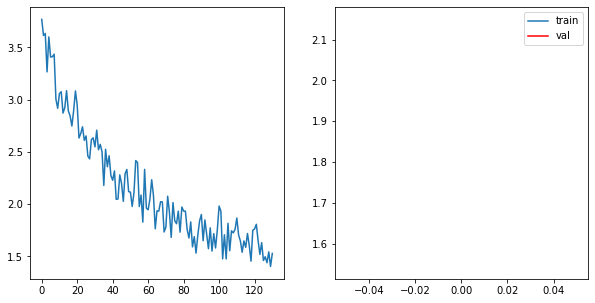

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(1.2904, grad_fn=<NllLossBackward0>)
tensor(1.5154, grad_fn=<NllLossBackward0>)
tensor(1.2115, grad_fn=<NllLossBackward0>)
tensor(1.5081, grad_fn=<NllLossBackward0>)
tensor(1.5462, grad_fn=<NllLossBackward0>)
tensor(1.4303, grad_fn=<NllLossBackward0>)
tensor(1.3568, grad_fn=<NllLossBackward0>)
tensor(1.3762, grad_fn=<NllLossBackward0>)
tensor(1.1063, grad_fn=<NllLossBackward0>)
tensor(1.3487, grad_fn=<NllLossBackward0>)
tensor(1.5262, grad_fn=<NllLossBackward0>)
tensor(1.4821, grad_fn=<NllLossBackward0>)
tensor(1.3525, grad_fn=<NllLossBackward0>)
tensor(1.2688, grad_fn=<NllLossBackward0>)
tensor(1.2865, grad_fn=<NllLossBackward0>)
tensor(1.2438, grad_fn=<NllLossBackward0>)
tensor(1.3606, grad_fn=<NllLossBackward0>)
tensor(1.1816, grad_fn=<NllLossBackward0>)
tensor(1.4942, grad_fn=<NllLossBackward0>)
tensor(1.5269, grad_fn=<NllLossBackward0>)
tensor(1.6783, grad_fn=<NllLossBackward0>)
tensor(1.4917, grad_fn=<NllLossBackward0>)
tensor(1.4447, grad_fn=<NllLossBackward0>)
tensor(1.46

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1	 \Training Loss: 1.2339321151944518	     Validation Loss:1.2541395606416645	 \ LR:0.0001


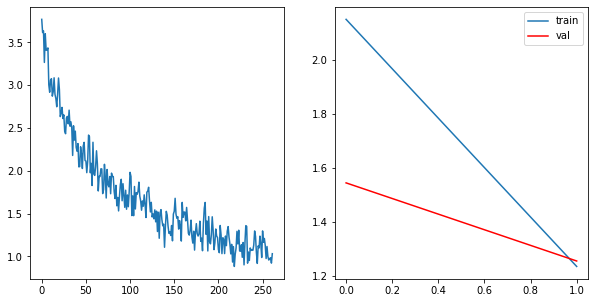

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.9757, grad_fn=<NllLossBackward0>)
tensor(1.0280, grad_fn=<NllLossBackward0>)
tensor(0.7312, grad_fn=<NllLossBackward0>)
tensor(1.0007, grad_fn=<NllLossBackward0>)
tensor(1.0861, grad_fn=<NllLossBackward0>)
tensor(1.0068, grad_fn=<NllLossBackward0>)
tensor(0.8504, grad_fn=<NllLossBackward0>)
tensor(0.8174, grad_fn=<NllLossBackward0>)
tensor(0.6227, grad_fn=<NllLossBackward0>)
tensor(0.9493, grad_fn=<NllLossBackward0>)
tensor(1.0112, grad_fn=<NllLossBackward0>)
tensor(1.0237, grad_fn=<NllLossBackward0>)
tensor(0.8934, grad_fn=<NllLossBackward0>)
tensor(0.7839, grad_fn=<NllLossBackward0>)
tensor(0.8080, grad_fn=<NllLossBackward0>)
tensor(0.8461, grad_fn=<NllLossBackward0>)
tensor(0.8639, grad_fn=<NllLossBackward0>)
tensor(0.8407, grad_fn=<NllLossBackward0>)
tensor(1.1224, grad_fn=<NllLossBackward0>)
tensor(1.0866, grad_fn=<NllLossBackward0>)
tensor(1.1156, grad_fn=<NllLossBackward0>)
tensor(1.0904, grad_fn=<NllLossBackward0>)
tensor(1.0007, grad_fn=<NllLossBackward0>)
tensor(1.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2	 \Training Loss: 0.8463513810216016	     Validation Loss:1.0346308368625063	 \ LR:0.0001


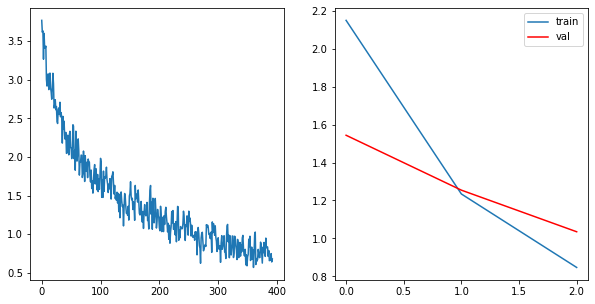

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.6933, grad_fn=<NllLossBackward0>)
tensor(0.7095, grad_fn=<NllLossBackward0>)
tensor(0.4940, grad_fn=<NllLossBackward0>)
tensor(0.7029, grad_fn=<NllLossBackward0>)
tensor(0.7278, grad_fn=<NllLossBackward0>)
tensor(0.6902, grad_fn=<NllLossBackward0>)
tensor(0.6126, grad_fn=<NllLossBackward0>)
tensor(0.5329, grad_fn=<NllLossBackward0>)
tensor(0.4084, grad_fn=<NllLossBackward0>)
tensor(0.7293, grad_fn=<NllLossBackward0>)
tensor(0.7863, grad_fn=<NllLossBackward0>)
tensor(0.7495, grad_fn=<NllLossBackward0>)
tensor(0.6420, grad_fn=<NllLossBackward0>)
tensor(0.5424, grad_fn=<NllLossBackward0>)
tensor(0.5737, grad_fn=<NllLossBackward0>)
tensor(0.5946, grad_fn=<NllLossBackward0>)
tensor(0.6270, grad_fn=<NllLossBackward0>)
tensor(0.6252, grad_fn=<NllLossBackward0>)
tensor(0.9250, grad_fn=<NllLossBackward0>)
tensor(0.8284, grad_fn=<NllLossBackward0>)
tensor(0.7349, grad_fn=<NllLossBackward0>)
tensor(0.8142, grad_fn=<NllLossBackward0>)
tensor(0.6782, grad_fn=<NllLossBackward0>)
tensor(0.74

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3	 \Training Loss: 0.6032250623666603	     Validation Loss:0.9163704261635289	 \ LR:0.0001


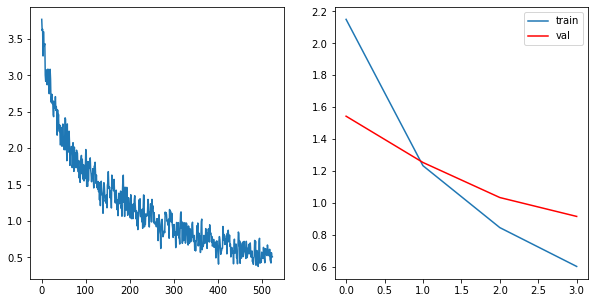

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.4913, grad_fn=<NllLossBackward0>)
tensor(0.4876, grad_fn=<NllLossBackward0>)
tensor(0.3333, grad_fn=<NllLossBackward0>)
tensor(0.5270, grad_fn=<NllLossBackward0>)
tensor(0.5255, grad_fn=<NllLossBackward0>)
tensor(0.4916, grad_fn=<NllLossBackward0>)
tensor(0.4480, grad_fn=<NllLossBackward0>)
tensor(0.3970, grad_fn=<NllLossBackward0>)
tensor(0.2871, grad_fn=<NllLossBackward0>)
tensor(0.5484, grad_fn=<NllLossBackward0>)
tensor(0.5887, grad_fn=<NllLossBackward0>)
tensor(0.5683, grad_fn=<NllLossBackward0>)
tensor(0.4882, grad_fn=<NllLossBackward0>)
tensor(0.3800, grad_fn=<NllLossBackward0>)
tensor(0.3759, grad_fn=<NllLossBackward0>)
tensor(0.4910, grad_fn=<NllLossBackward0>)
tensor(0.5003, grad_fn=<NllLossBackward0>)
tensor(0.5083, grad_fn=<NllLossBackward0>)
tensor(0.7213, grad_fn=<NllLossBackward0>)
tensor(0.6375, grad_fn=<NllLossBackward0>)
tensor(0.5537, grad_fn=<NllLossBackward0>)
tensor(0.6314, grad_fn=<NllLossBackward0>)
tensor(0.5006, grad_fn=<NllLossBackward0>)
tensor(0.54

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4	 \Training Loss: 0.43417248391468105	     Validation Loss:0.8805887825561293	 \ LR:0.0001


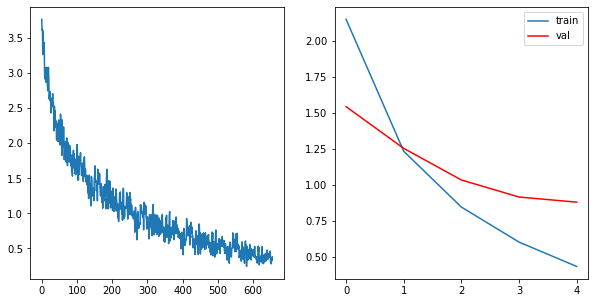

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.3459, grad_fn=<NllLossBackward0>)
tensor(0.3740, grad_fn=<NllLossBackward0>)
tensor(0.2245, grad_fn=<NllLossBackward0>)
tensor(0.3457, grad_fn=<NllLossBackward0>)
tensor(0.3731, grad_fn=<NllLossBackward0>)
tensor(0.3165, grad_fn=<NllLossBackward0>)
tensor(0.3077, grad_fn=<NllLossBackward0>)
tensor(0.2403, grad_fn=<NllLossBackward0>)
tensor(0.1865, grad_fn=<NllLossBackward0>)
tensor(0.4052, grad_fn=<NllLossBackward0>)
tensor(0.4238, grad_fn=<NllLossBackward0>)
tensor(0.4224, grad_fn=<NllLossBackward0>)
tensor(0.3584, grad_fn=<NllLossBackward0>)
tensor(0.2625, grad_fn=<NllLossBackward0>)
tensor(0.2509, grad_fn=<NllLossBackward0>)
tensor(0.3336, grad_fn=<NllLossBackward0>)
tensor(0.4145, grad_fn=<NllLossBackward0>)
tensor(0.3991, grad_fn=<NllLossBackward0>)
tensor(0.4680, grad_fn=<NllLossBackward0>)
tensor(0.4538, grad_fn=<NllLossBackward0>)
tensor(0.3856, grad_fn=<NllLossBackward0>)
tensor(0.4503, grad_fn=<NllLossBackward0>)
tensor(0.3929, grad_fn=<NllLossBackward0>)
tensor(0.44

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5	 \Training Loss: 0.3163593294283816	     Validation Loss:0.8803091049194336	 \ LR:0.0001


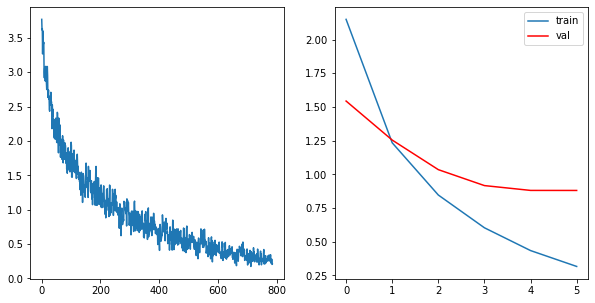

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.2372, grad_fn=<NllLossBackward0>)
tensor(0.2803, grad_fn=<NllLossBackward0>)
tensor(0.1610, grad_fn=<NllLossBackward0>)
tensor(0.2063, grad_fn=<NllLossBackward0>)
tensor(0.2436, grad_fn=<NllLossBackward0>)
tensor(0.2285, grad_fn=<NllLossBackward0>)
tensor(0.2134, grad_fn=<NllLossBackward0>)
tensor(0.1656, grad_fn=<NllLossBackward0>)
tensor(0.1140, grad_fn=<NllLossBackward0>)
tensor(0.2751, grad_fn=<NllLossBackward0>)
tensor(0.2519, grad_fn=<NllLossBackward0>)
tensor(0.2969, grad_fn=<NllLossBackward0>)
tensor(0.2494, grad_fn=<NllLossBackward0>)
tensor(0.1920, grad_fn=<NllLossBackward0>)
tensor(0.1884, grad_fn=<NllLossBackward0>)
tensor(0.2079, grad_fn=<NllLossBackward0>)
tensor(0.2422, grad_fn=<NllLossBackward0>)
tensor(0.2587, grad_fn=<NllLossBackward0>)
tensor(0.3522, grad_fn=<NllLossBackward0>)
tensor(0.3979, grad_fn=<NllLossBackward0>)
tensor(0.2250, grad_fn=<NllLossBackward0>)
tensor(0.2585, grad_fn=<NllLossBackward0>)
tensor(0.2385, grad_fn=<NllLossBackward0>)
tensor(0.34

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6	 \Training Loss: 0.24256470953007692	     Validation Loss:0.7906214576778989	 \ LR:0.0001


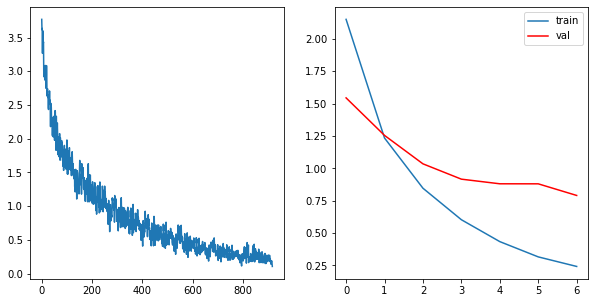

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.1437, grad_fn=<NllLossBackward0>)
tensor(0.1682, grad_fn=<NllLossBackward0>)
tensor(0.0985, grad_fn=<NllLossBackward0>)
tensor(0.1646, grad_fn=<NllLossBackward0>)
tensor(0.1464, grad_fn=<NllLossBackward0>)
tensor(0.1309, grad_fn=<NllLossBackward0>)
tensor(0.1356, grad_fn=<NllLossBackward0>)
tensor(0.0986, grad_fn=<NllLossBackward0>)
tensor(0.0792, grad_fn=<NllLossBackward0>)
tensor(0.2009, grad_fn=<NllLossBackward0>)
tensor(0.2018, grad_fn=<NllLossBackward0>)
tensor(0.2308, grad_fn=<NllLossBackward0>)
tensor(0.1531, grad_fn=<NllLossBackward0>)
tensor(0.1351, grad_fn=<NllLossBackward0>)
tensor(0.1354, grad_fn=<NllLossBackward0>)
tensor(0.1301, grad_fn=<NllLossBackward0>)
tensor(0.1696, grad_fn=<NllLossBackward0>)
tensor(0.1496, grad_fn=<NllLossBackward0>)
tensor(0.2357, grad_fn=<NllLossBackward0>)
tensor(0.1979, grad_fn=<NllLossBackward0>)
tensor(0.1859, grad_fn=<NllLossBackward0>)
tensor(0.1653, grad_fn=<NllLossBackward0>)
tensor(0.1759, grad_fn=<NllLossBackward0>)
tensor(0.21

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7	 \Training Loss: 0.17380446707474367	     Validation Loss:0.8279866485884695	 \ LR:0.0001


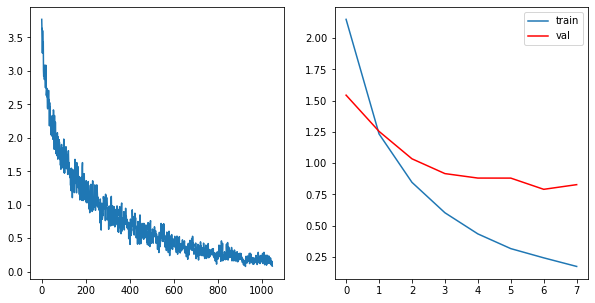

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.1177, grad_fn=<NllLossBackward0>)
tensor(0.1203, grad_fn=<NllLossBackward0>)
tensor(0.0638, grad_fn=<NllLossBackward0>)
tensor(0.1116, grad_fn=<NllLossBackward0>)
tensor(0.1017, grad_fn=<NllLossBackward0>)
tensor(0.0836, grad_fn=<NllLossBackward0>)
tensor(0.1093, grad_fn=<NllLossBackward0>)
tensor(0.0765, grad_fn=<NllLossBackward0>)
tensor(0.0769, grad_fn=<NllLossBackward0>)
tensor(0.1157, grad_fn=<NllLossBackward0>)
tensor(0.1391, grad_fn=<NllLossBackward0>)
tensor(0.1617, grad_fn=<NllLossBackward0>)
tensor(0.0954, grad_fn=<NllLossBackward0>)
tensor(0.0897, grad_fn=<NllLossBackward0>)
tensor(0.0979, grad_fn=<NllLossBackward0>)
tensor(0.1050, grad_fn=<NllLossBackward0>)
tensor(0.1455, grad_fn=<NllLossBackward0>)
tensor(0.1139, grad_fn=<NllLossBackward0>)
tensor(0.1350, grad_fn=<NllLossBackward0>)
tensor(0.1420, grad_fn=<NllLossBackward0>)
tensor(0.1196, grad_fn=<NllLossBackward0>)
tensor(0.1078, grad_fn=<NllLossBackward0>)
tensor(0.1009, grad_fn=<NllLossBackward0>)
tensor(0.15

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8	 \Training Loss: 0.11806687701294441	     Validation Loss:0.9237573508060339	 \ LR:0.0001


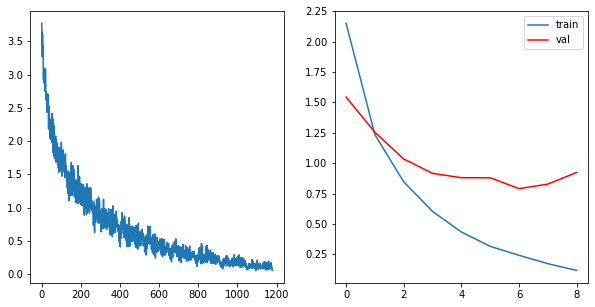

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0976, grad_fn=<NllLossBackward0>)
tensor(0.1064, grad_fn=<NllLossBackward0>)
tensor(0.1165, grad_fn=<NllLossBackward0>)
tensor(0.1460, grad_fn=<NllLossBackward0>)
tensor(0.0866, grad_fn=<NllLossBackward0>)
tensor(0.0647, grad_fn=<NllLossBackward0>)
tensor(0.0869, grad_fn=<NllLossBackward0>)
tensor(0.0653, grad_fn=<NllLossBackward0>)
tensor(0.0681, grad_fn=<NllLossBackward0>)
tensor(0.1291, grad_fn=<NllLossBackward0>)
tensor(0.1012, grad_fn=<NllLossBackward0>)
tensor(0.1450, grad_fn=<NllLossBackward0>)
tensor(0.0669, grad_fn=<NllLossBackward0>)
tensor(0.0654, grad_fn=<NllLossBackward0>)
tensor(0.0593, grad_fn=<NllLossBackward0>)
tensor(0.1017, grad_fn=<NllLossBackward0>)
tensor(0.1001, grad_fn=<NllLossBackward0>)
tensor(0.0790, grad_fn=<NllLossBackward0>)
tensor(0.1124, grad_fn=<NllLossBackward0>)
tensor(0.1111, grad_fn=<NllLossBackward0>)
tensor(0.0860, grad_fn=<NllLossBackward0>)
tensor(0.0719, grad_fn=<NllLossBackward0>)
tensor(0.0820, grad_fn=<NllLossBackward0>)
tensor(0.09

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9	 \Training Loss: 0.09513754687691463	     Validation Loss:0.9133606932379983	 \ LR:0.0001


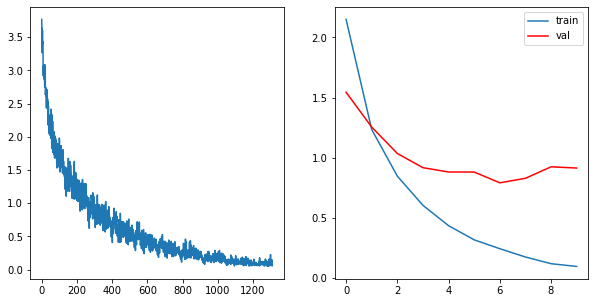

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.1165, grad_fn=<NllLossBackward0>)
tensor(0.0983, grad_fn=<NllLossBackward0>)
tensor(0.0550, grad_fn=<NllLossBackward0>)
tensor(0.0616, grad_fn=<NllLossBackward0>)
tensor(0.0714, grad_fn=<NllLossBackward0>)
tensor(0.0985, grad_fn=<NllLossBackward0>)
tensor(0.1480, grad_fn=<NllLossBackward0>)
tensor(0.1360, grad_fn=<NllLossBackward0>)
tensor(0.0516, grad_fn=<NllLossBackward0>)
tensor(0.0626, grad_fn=<NllLossBackward0>)
tensor(0.0589, grad_fn=<NllLossBackward0>)
tensor(0.0992, grad_fn=<NllLossBackward0>)
tensor(0.1046, grad_fn=<NllLossBackward0>)
tensor(0.0986, grad_fn=<NllLossBackward0>)
tensor(0.0519, grad_fn=<NllLossBackward0>)
tensor(0.0617, grad_fn=<NllLossBackward0>)
tensor(0.0852, grad_fn=<NllLossBackward0>)
tensor(0.0787, grad_fn=<NllLossBackward0>)
tensor(0.1047, grad_fn=<NllLossBackward0>)
tensor(0.0687, grad_fn=<NllLossBackward0>)
tensor(0.0846, grad_fn=<NllLossBackward0>)
tensor(0.0513, grad_fn=<NllLossBackward0>)
tensor(0.0586, grad_fn=<NllLossBackward0>)
tensor(0.08

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10	 \Training Loss: 0.08727086477607261	     Validation Loss:0.9234208843924783	 \ LR:0.0001


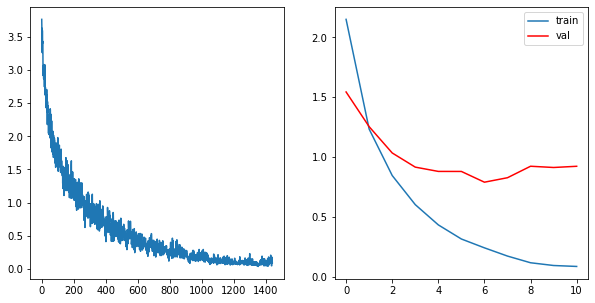

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0734, grad_fn=<NllLossBackward0>)
tensor(0.0842, grad_fn=<NllLossBackward0>)
tensor(0.0606, grad_fn=<NllLossBackward0>)
tensor(0.0809, grad_fn=<NllLossBackward0>)
tensor(0.1019, grad_fn=<NllLossBackward0>)
tensor(0.0734, grad_fn=<NllLossBackward0>)
tensor(0.1396, grad_fn=<NllLossBackward0>)
tensor(0.1790, grad_fn=<NllLossBackward0>)
tensor(0.0800, grad_fn=<NllLossBackward0>)
tensor(0.0428, grad_fn=<NllLossBackward0>)
tensor(0.0402, grad_fn=<NllLossBackward0>)
tensor(0.0606, grad_fn=<NllLossBackward0>)
tensor(0.0683, grad_fn=<NllLossBackward0>)
tensor(0.1310, grad_fn=<NllLossBackward0>)
tensor(0.1095, grad_fn=<NllLossBackward0>)
tensor(0.0500, grad_fn=<NllLossBackward0>)
tensor(0.0870, grad_fn=<NllLossBackward0>)
tensor(0.0675, grad_fn=<NllLossBackward0>)
tensor(0.0824, grad_fn=<NllLossBackward0>)
tensor(0.0737, grad_fn=<NllLossBackward0>)
tensor(0.0499, grad_fn=<NllLossBackward0>)
tensor(0.0518, grad_fn=<NllLossBackward0>)
tensor(0.0610, grad_fn=<NllLossBackward0>)
tensor(0.07

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11	 \Training Loss: 0.05295841516713605	     Validation Loss:0.8093377243388783	 \ LR:0.0001


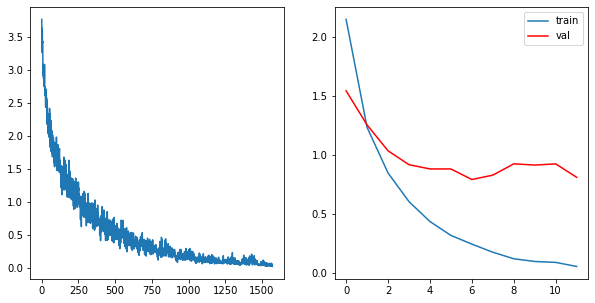

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0279, grad_fn=<NllLossBackward0>)
tensor(0.0410, grad_fn=<NllLossBackward0>)
tensor(0.0274, grad_fn=<NllLossBackward0>)
tensor(0.0624, grad_fn=<NllLossBackward0>)
tensor(0.0760, grad_fn=<NllLossBackward0>)
tensor(0.0367, grad_fn=<NllLossBackward0>)
tensor(0.0324, grad_fn=<NllLossBackward0>)
tensor(0.0139, grad_fn=<NllLossBackward0>)
tensor(0.0158, grad_fn=<NllLossBackward0>)
tensor(0.0334, grad_fn=<NllLossBackward0>)
tensor(0.0559, grad_fn=<NllLossBackward0>)
tensor(0.0581, grad_fn=<NllLossBackward0>)
tensor(0.0234, grad_fn=<NllLossBackward0>)
tensor(0.0327, grad_fn=<NllLossBackward0>)
tensor(0.0501, grad_fn=<NllLossBackward0>)
tensor(0.0344, grad_fn=<NllLossBackward0>)
tensor(0.0292, grad_fn=<NllLossBackward0>)
tensor(0.0345, grad_fn=<NllLossBackward0>)
tensor(0.0496, grad_fn=<NllLossBackward0>)
tensor(0.0317, grad_fn=<NllLossBackward0>)
tensor(0.0401, grad_fn=<NllLossBackward0>)
tensor(0.0382, grad_fn=<NllLossBackward0>)
tensor(0.0484, grad_fn=<NllLossBackward0>)
tensor(0.04

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12	 \Training Loss: 0.03516732385197214	     Validation Loss:0.7684242409287076	 \ LR:0.0001


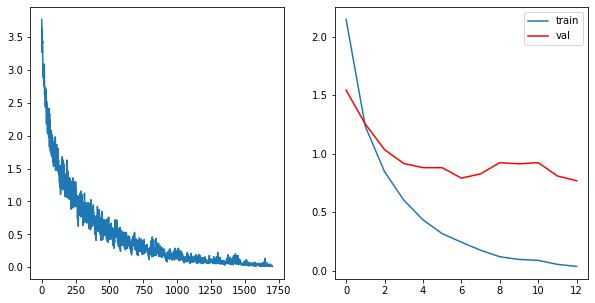

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0235, grad_fn=<NllLossBackward0>)
tensor(0.0158, grad_fn=<NllLossBackward0>)
tensor(0.0148, grad_fn=<NllLossBackward0>)
tensor(0.0346, grad_fn=<NllLossBackward0>)
tensor(0.0256, grad_fn=<NllLossBackward0>)
tensor(0.0183, grad_fn=<NllLossBackward0>)
tensor(0.0226, grad_fn=<NllLossBackward0>)
tensor(0.0087, grad_fn=<NllLossBackward0>)
tensor(0.0118, grad_fn=<NllLossBackward0>)
tensor(0.0191, grad_fn=<NllLossBackward0>)
tensor(0.0365, grad_fn=<NllLossBackward0>)
tensor(0.0234, grad_fn=<NllLossBackward0>)
tensor(0.0150, grad_fn=<NllLossBackward0>)
tensor(0.0169, grad_fn=<NllLossBackward0>)
tensor(0.0392, grad_fn=<NllLossBackward0>)
tensor(0.0199, grad_fn=<NllLossBackward0>)
tensor(0.0151, grad_fn=<NllLossBackward0>)
tensor(0.0203, grad_fn=<NllLossBackward0>)
tensor(0.0138, grad_fn=<NllLossBackward0>)
tensor(0.0390, grad_fn=<NllLossBackward0>)
tensor(0.0233, grad_fn=<NllLossBackward0>)
tensor(0.0252, grad_fn=<NllLossBackward0>)
tensor(0.0300, grad_fn=<NllLossBackward0>)
tensor(0.03

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13	 \Training Loss: 0.019648151685490865	     Validation Loss:0.7991021510326501	 \ LR:0.0001


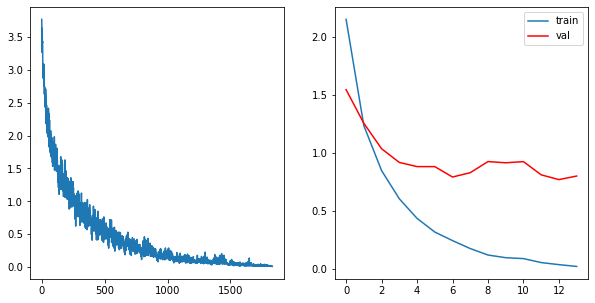

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0096, grad_fn=<NllLossBackward0>)
tensor(0.0148, grad_fn=<NllLossBackward0>)
tensor(0.0112, grad_fn=<NllLossBackward0>)
tensor(0.0132, grad_fn=<NllLossBackward0>)
tensor(0.0172, grad_fn=<NllLossBackward0>)
tensor(0.0112, grad_fn=<NllLossBackward0>)
tensor(0.0118, grad_fn=<NllLossBackward0>)
tensor(0.0075, grad_fn=<NllLossBackward0>)
tensor(0.0065, grad_fn=<NllLossBackward0>)
tensor(0.0134, grad_fn=<NllLossBackward0>)
tensor(0.0169, grad_fn=<NllLossBackward0>)
tensor(0.0209, grad_fn=<NllLossBackward0>)
tensor(0.0159, grad_fn=<NllLossBackward0>)
tensor(0.0193, grad_fn=<NllLossBackward0>)
tensor(0.0435, grad_fn=<NllLossBackward0>)
tensor(0.0138, grad_fn=<NllLossBackward0>)
tensor(0.0101, grad_fn=<NllLossBackward0>)
tensor(0.0133, grad_fn=<NllLossBackward0>)
tensor(0.0113, grad_fn=<NllLossBackward0>)
tensor(0.0217, grad_fn=<NllLossBackward0>)
tensor(0.0117, grad_fn=<NllLossBackward0>)
tensor(0.0194, grad_fn=<NllLossBackward0>)
tensor(0.0164, grad_fn=<NllLossBackward0>)
tensor(0.01

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14	 \Training Loss: 0.013609457348707978	     Validation Loss:0.7522737275470387	 \ LR:0.0001


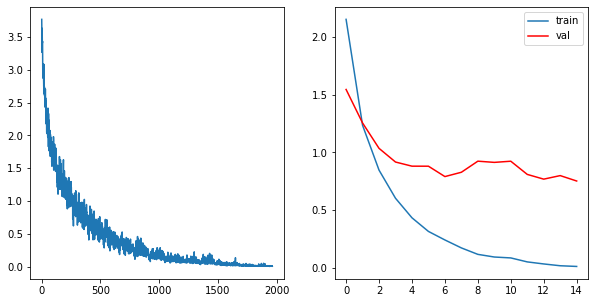

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0069, grad_fn=<NllLossBackward0>)
tensor(0.0085, grad_fn=<NllLossBackward0>)
tensor(0.0084, grad_fn=<NllLossBackward0>)
tensor(0.0071, grad_fn=<NllLossBackward0>)
tensor(0.0110, grad_fn=<NllLossBackward0>)
tensor(0.0068, grad_fn=<NllLossBackward0>)
tensor(0.0081, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0091, grad_fn=<NllLossBackward0>)
tensor(0.0121, grad_fn=<NllLossBackward0>)
tensor(0.0100, grad_fn=<NllLossBackward0>)
tensor(0.0135, grad_fn=<NllLossBackward0>)
tensor(0.0095, grad_fn=<NllLossBackward0>)
tensor(0.0365, grad_fn=<NllLossBackward0>)
tensor(0.0076, grad_fn=<NllLossBackward0>)
tensor(0.0085, grad_fn=<NllLossBackward0>)
tensor(0.0085, grad_fn=<NllLossBackward0>)
tensor(0.0097, grad_fn=<NllLossBackward0>)
tensor(0.0096, grad_fn=<NllLossBackward0>)
tensor(0.0088, grad_fn=<NllLossBackward0>)
tensor(0.0128, grad_fn=<NllLossBackward0>)
tensor(0.0079, grad_fn=<NllLossBackward0>)
tensor(0.01

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15	 \Training Loss: 0.010123672752946842	     Validation Loss:0.7610833166223584	 \ LR:0.0001


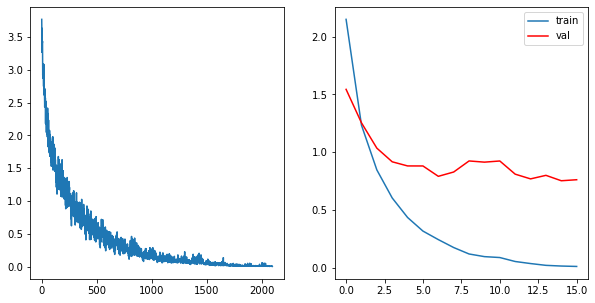

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0062, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0065, grad_fn=<NllLossBackward0>)
tensor(0.0070, grad_fn=<NllLossBackward0>)
tensor(0.0091, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0058, grad_fn=<NllLossBackward0>)
tensor(0.0063, grad_fn=<NllLossBackward0>)
tensor(0.0072, grad_fn=<NllLossBackward0>)
tensor(0.0067, grad_fn=<NllLossBackward0>)
tensor(0.0349, grad_fn=<NllLossBackward0>)
tensor(0.0074, grad_fn=<NllLossBackward0>)
tensor(0.0064, grad_fn=<NllLossBackward0>)
tensor(0.0070, grad_fn=<NllLossBackward0>)
tensor(0.0063, grad_fn=<NllLossBackward0>)
tensor(0.0065, grad_fn=<NllLossBackward0>)
tensor(0.0072, grad_fn=<NllLossBackward0>)
tensor(0.0074, grad_fn=<NllLossBackward0>)
tensor(0.0052, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16	 \Training Loss: 0.007677068942731232	     Validation Loss:0.7454886355183341	 \ LR:0.0001


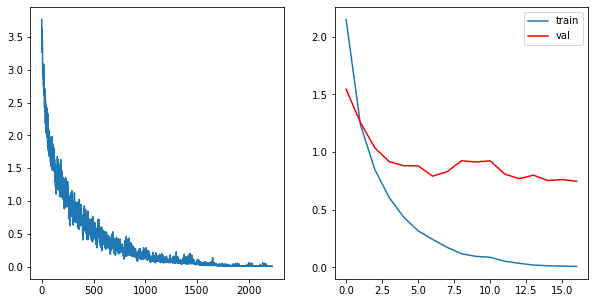

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0050, grad_fn=<NllLossBackward0>)
tensor(0.0060, grad_fn=<NllLossBackward0>)
tensor(0.0044, grad_fn=<NllLossBackward0>)
tensor(0.0047, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0046, grad_fn=<NllLossBackward0>)
tensor(0.0047, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0307, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0056, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0051, grad_fn=<NllLossBackward0>)
tensor(0.0060, grad_fn=<NllLossBackward0>)
tensor(0.0056, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17	 \Training Loss: 0.006192382869403099	     Validation Loss:0.7462724013762041	 \ LR:0.0001


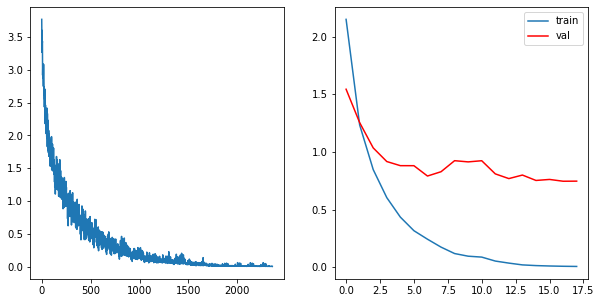

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0049, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.0319, grad_fn=<NllLossBackward0>)
tensor(0.0041, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0049, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0052, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18	 \Training Loss: 0.0053507345995176155	     Validation Loss:0.7490348617235819	 \ LR:0.0001


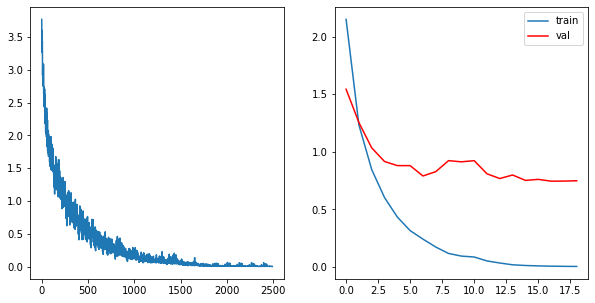

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0043, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0047, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0038, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0312, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0045, grad_fn=<NllLossBackward0>)
tensor(0.0039, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19	 \Training Loss: 0.004749799353418915	     Validation Loss:0.752541723576459	 \ LR:0.0001


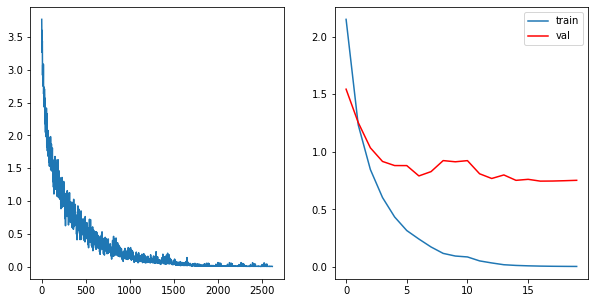

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0316, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0037, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0040, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20	 \Training Loss: 0.004314971849578255	     Validation Loss:0.7568798941193204	 \ LR:0.0001


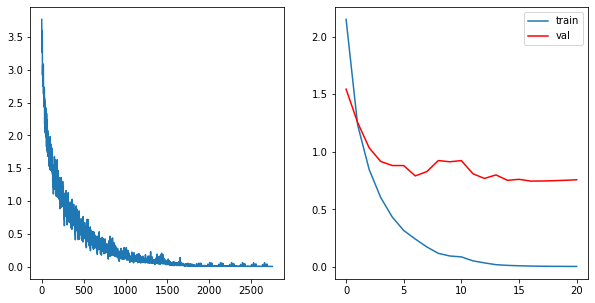

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0333, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0031, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21	 \Training Loss: 0.004013557793956449	     Validation Loss:0.760962727394971	 \ LR:0.0001


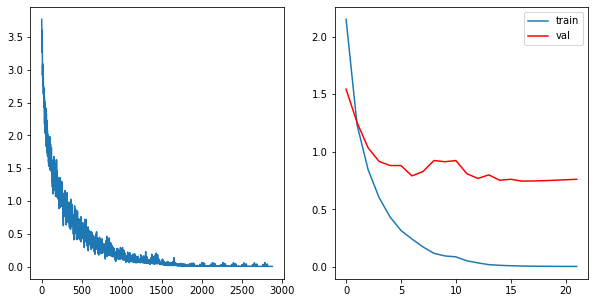

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0028, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0345, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0029, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22	 \Training Loss: 0.003748877165938607	     Validation Loss:0.7655740046139919	 \ LR:1e-05


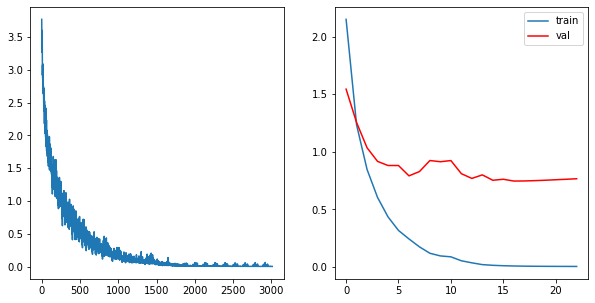

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0032, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0410, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23	 \Training Loss: 0.002610499618702945	     Validation Loss:0.7634487721053037	 \ LR:1e-05


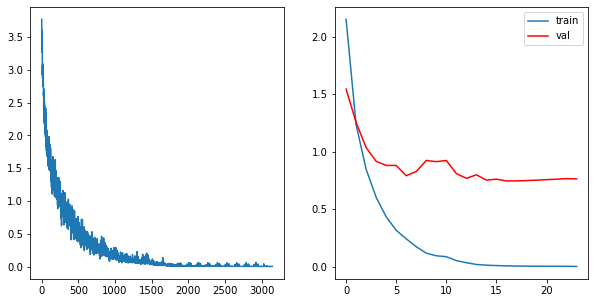

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0186, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24	 \Training Loss: 0.0022450846954042676	     Validation Loss:0.7629695841760347	 \ LR:1e-05


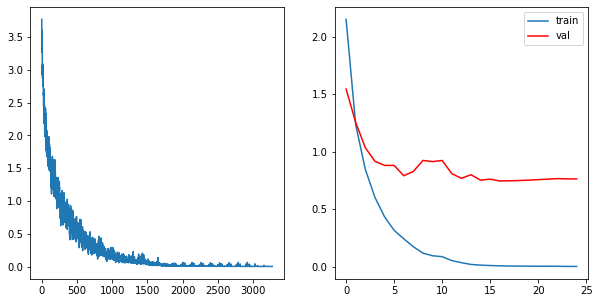

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25	 \Training Loss: 0.002074163143153352	     Validation Loss:0.7629751843033414	 \ LR:1e-05


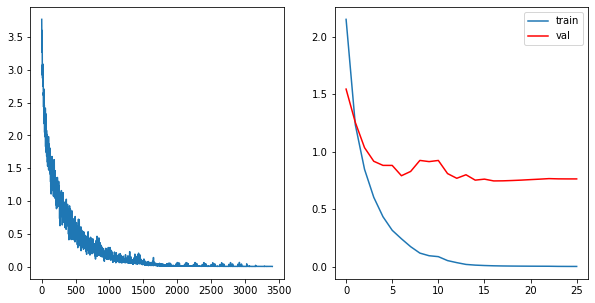

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26	 \Training Loss: 0.002012591330931728	     Validation Loss:0.763217340816151	 \ LR:1e-05


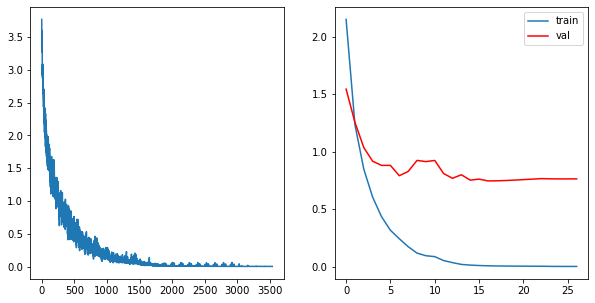

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27	 \Training Loss: 0.001968906544511498	     Validation Loss:0.7635484979008184	 \ LR:1e-05


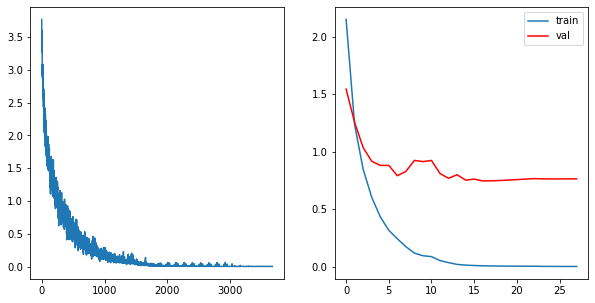

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0026, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28	 \Training Loss: 0.0019301444830600429	     Validation Loss:0.76394092223861	 \ LR:1.0000000000000002e-06


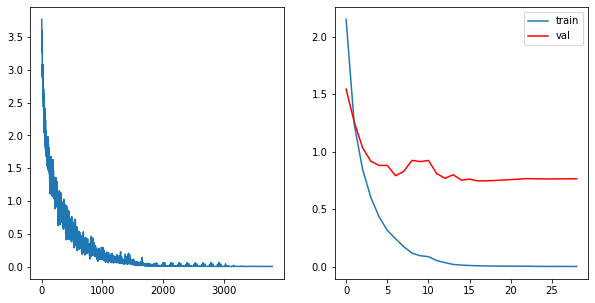

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0013, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29	 \Training Loss: 0.0018612685327183541	     Validation Loss:0.7638396711060496	 \ LR:1.0000000000000002e-06


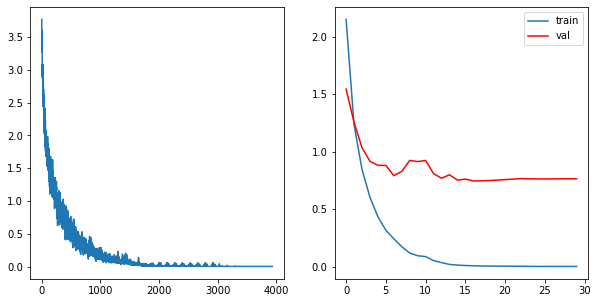

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30	 \Training Loss: 0.0018555612244664599	     Validation Loss:0.7637770762949279	 \ LR:1.0000000000000002e-06


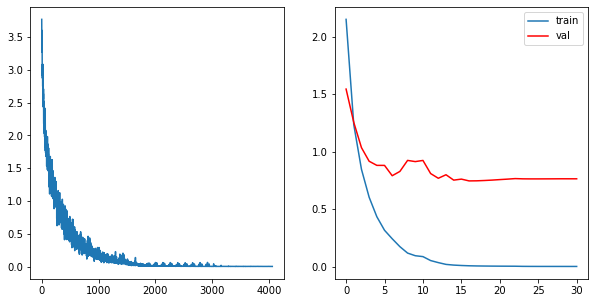

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0015, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.00

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31	 \Training Loss: 0.0018504339924352315	     Validation Loss:0.7637530420765732	 \ LR:1.0000000000000002e-06


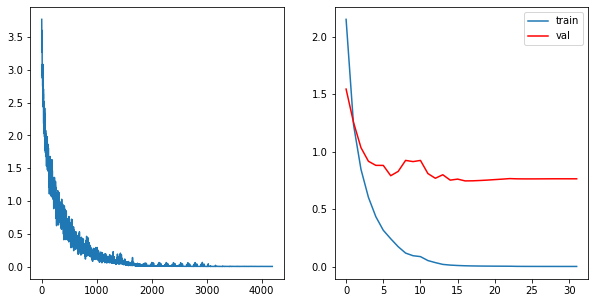

  0%|          | 0/131 [00:00<?, ?it/s]

tensor(0.0017, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.0025, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0022, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0018, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: 

In [21]:
from torch.autograd import Variable
from tqdm.notebook import tqdm
step_losses = []
epoch_losses_train = []
epoch_losses_val = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_loss_test = 0
    model.train()
    for X, Y in tqdm(data_loader_train, total=len(data_loader_train)):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        print(loss)
    if epoch % 5 == 0:
        state = {'info':  "baseline simpsons resnet"+str(optimizer.param_groups[0]['lr']),            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
        torch.save(state, '/baseline simpsons_res_net' + str(epoch)+ '.pth')
    with torch.no_grad():
        model.eval()
        for X, Y in tqdm(data_loader_val, total=len(data_loader_val), leave=False):
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)
            loss_test = criterion(Y_pred, Y)
            epoch_loss_test += loss_test.item()
    epoch_losses_val.append(epoch_loss_test/len(data_loader_val))
    epoch_losses_train.append(epoch_loss/len(data_loader_train))
    scheduler.step(epoch_loss_test/len(data_loader_val))
    curr_lr = optimizer.param_groups[0]['lr']
  
    print(f'Epoch {epoch}\t \Training Loss: {epoch_loss/len(data_loader_train)}\t \
    Validation Loss:{epoch_loss_test/len(data_loader_val)}\t \ LR:{curr_lr}')
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(step_losses)
    axes[1].plot(epoch_losses_train, label = 'train')
    axes[1].plot(epoch_losses_val, color = 'red', label = 'val')
    axes[1].legend()
    plt.show()


Данная модель уже обучалась на всем датасате, а валидация состоит из 20% тренировочного. С использованием аугументаций. Но даучить данную модель уже не успеваю. 30 эпоха дала качесто 0,9 на кагле. Но судя по графику, лосс еще упадет, а качество повысится

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(3.8351, grad_fn=<NllLossBackward0>)
tensor(3.2654, grad_fn=<NllLossBackward0>)
tensor(3.6015, grad_fn=<NllLossBackward0>)
tensor(3.4526, grad_fn=<NllLossBackward0>)
tensor(3.2168, grad_fn=<NllLossBackward0>)
tensor(3.1845, grad_fn=<NllLossBackward0>)
tensor(3.2428, grad_fn=<NllLossBackward0>)
tensor(3.3015, grad_fn=<NllLossBackward0>)
tensor(3.0903, grad_fn=<NllLossBackward0>)
tensor(3.1054, grad_fn=<NllLossBackward0>)
tensor(3.1019, grad_fn=<NllLossBackward0>)
tensor(3.0202, grad_fn=<NllLossBackward0>)
tensor(3.1265, grad_fn=<NllLossBackward0>)
tensor(3.2171, grad_fn=<NllLossBackward0>)
tensor(3.0062, grad_fn=<NllLossBackward0>)
tensor(2.9009, grad_fn=<NllLossBackward0>)
tensor(3.0172, grad_fn=<NllLossBackward0>)
tensor(3.0546, grad_fn=<NllLossBackward0>)
tensor(2.9897, grad_fn=<NllLossBackward0>)
tensor(2.8492, grad_fn=<NllLossBackward0>)
tensor(2.8439, grad_fn=<NllLossBackward0>)
tensor(2.8161, grad_fn=<NllLossBackward0>)
tensor(2.8772, grad_fn=<NllLossBackward0>)
tensor(2.79

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0	 \Training Loss: 2.6733947846947648	     Validation Loss:2.15638048508588	 \ LR:0.0001


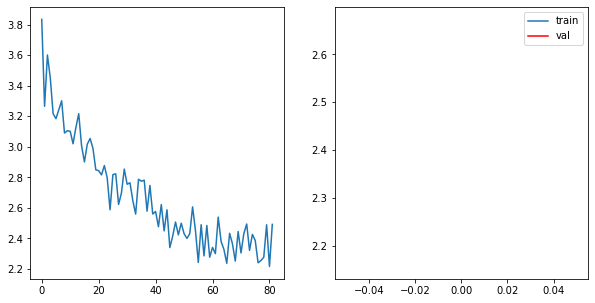

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(2.3664, grad_fn=<NllLossBackward0>)
tensor(2.1765, grad_fn=<NllLossBackward0>)
tensor(2.0497, grad_fn=<NllLossBackward0>)
tensor(2.1754, grad_fn=<NllLossBackward0>)
tensor(2.1628, grad_fn=<NllLossBackward0>)
tensor(2.1558, grad_fn=<NllLossBackward0>)
tensor(2.1129, grad_fn=<NllLossBackward0>)
tensor(2.2813, grad_fn=<NllLossBackward0>)
tensor(2.2185, grad_fn=<NllLossBackward0>)
tensor(2.2180, grad_fn=<NllLossBackward0>)
tensor(2.2579, grad_fn=<NllLossBackward0>)
tensor(2.2113, grad_fn=<NllLossBackward0>)
tensor(2.2019, grad_fn=<NllLossBackward0>)
tensor(2.0406, grad_fn=<NllLossBackward0>)
tensor(2.0461, grad_fn=<NllLossBackward0>)
tensor(1.9893, grad_fn=<NllLossBackward0>)
tensor(1.9920, grad_fn=<NllLossBackward0>)
tensor(2.2057, grad_fn=<NllLossBackward0>)
tensor(2.0821, grad_fn=<NllLossBackward0>)
tensor(2.1007, grad_fn=<NllLossBackward0>)
tensor(2.1366, grad_fn=<NllLossBackward0>)
tensor(2.1580, grad_fn=<NllLossBackward0>)
tensor(2.0611, grad_fn=<NllLossBackward0>)
tensor(2.00

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1	 \Training Loss: 2.018356267998858	     Validation Loss:1.7621718995711382	 \ LR:0.0001


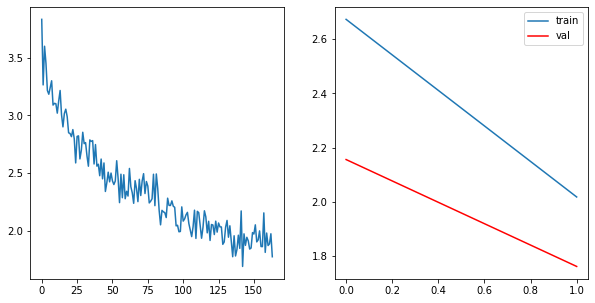

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(1.8112, grad_fn=<NllLossBackward0>)
tensor(2.0234, grad_fn=<NllLossBackward0>)
tensor(1.7367, grad_fn=<NllLossBackward0>)
tensor(1.8492, grad_fn=<NllLossBackward0>)
tensor(1.9240, grad_fn=<NllLossBackward0>)
tensor(1.8101, grad_fn=<NllLossBackward0>)
tensor(1.5679, grad_fn=<NllLossBackward0>)
tensor(1.8777, grad_fn=<NllLossBackward0>)
tensor(1.8357, grad_fn=<NllLossBackward0>)
tensor(1.8240, grad_fn=<NllLossBackward0>)
tensor(1.8086, grad_fn=<NllLossBackward0>)
tensor(1.8246, grad_fn=<NllLossBackward0>)
tensor(1.6283, grad_fn=<NllLossBackward0>)
tensor(1.7693, grad_fn=<NllLossBackward0>)
tensor(1.7837, grad_fn=<NllLossBackward0>)
tensor(1.8161, grad_fn=<NllLossBackward0>)
tensor(1.7673, grad_fn=<NllLossBackward0>)
tensor(1.6538, grad_fn=<NllLossBackward0>)
tensor(1.8023, grad_fn=<NllLossBackward0>)
tensor(1.6335, grad_fn=<NllLossBackward0>)
tensor(1.6414, grad_fn=<NllLossBackward0>)
tensor(1.6533, grad_fn=<NllLossBackward0>)
tensor(1.7590, grad_fn=<NllLossBackward0>)
tensor(1.91

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2	 \Training Loss: 1.686600304231411	     Validation Loss:1.4530811730553121	 \ LR:0.0001


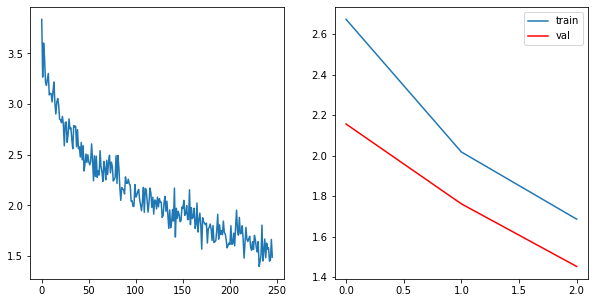

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(1.4184, grad_fn=<NllLossBackward0>)
tensor(1.6201, grad_fn=<NllLossBackward0>)
tensor(1.6646, grad_fn=<NllLossBackward0>)
tensor(1.3573, grad_fn=<NllLossBackward0>)
tensor(1.4270, grad_fn=<NllLossBackward0>)
tensor(1.7108, grad_fn=<NllLossBackward0>)
tensor(1.3607, grad_fn=<NllLossBackward0>)
tensor(1.5026, grad_fn=<NllLossBackward0>)
tensor(1.5213, grad_fn=<NllLossBackward0>)
tensor(1.4668, grad_fn=<NllLossBackward0>)
tensor(1.4895, grad_fn=<NllLossBackward0>)
tensor(1.5080, grad_fn=<NllLossBackward0>)
tensor(1.4082, grad_fn=<NllLossBackward0>)
tensor(1.5248, grad_fn=<NllLossBackward0>)
tensor(1.6832, grad_fn=<NllLossBackward0>)
tensor(1.6840, grad_fn=<NllLossBackward0>)
tensor(1.3255, grad_fn=<NllLossBackward0>)
tensor(1.2787, grad_fn=<NllLossBackward0>)
tensor(1.3964, grad_fn=<NllLossBackward0>)
tensor(1.4228, grad_fn=<NllLossBackward0>)
tensor(1.5850, grad_fn=<NllLossBackward0>)
tensor(1.3559, grad_fn=<NllLossBackward0>)
tensor(1.5312, grad_fn=<NllLossBackward0>)
tensor(1.56

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3	 \Training Loss: 1.4445984029188388	     Validation Loss:1.254991755766027	 \ LR:0.0001


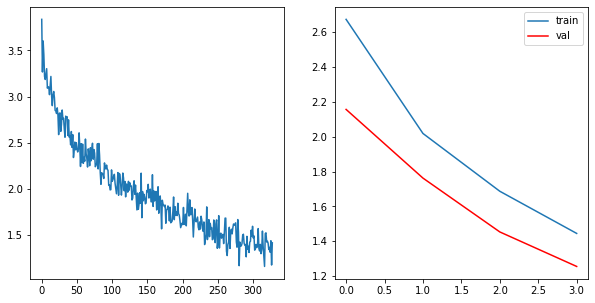

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(1.2370, grad_fn=<NllLossBackward0>)
tensor(1.4302, grad_fn=<NllLossBackward0>)
tensor(1.3051, grad_fn=<NllLossBackward0>)
tensor(1.2450, grad_fn=<NllLossBackward0>)
tensor(1.2432, grad_fn=<NllLossBackward0>)
tensor(1.4192, grad_fn=<NllLossBackward0>)
tensor(1.5996, grad_fn=<NllLossBackward0>)
tensor(1.3141, grad_fn=<NllLossBackward0>)
tensor(1.4802, grad_fn=<NllLossBackward0>)
tensor(1.2392, grad_fn=<NllLossBackward0>)
tensor(1.3409, grad_fn=<NllLossBackward0>)
tensor(1.3892, grad_fn=<NllLossBackward0>)
tensor(1.2044, grad_fn=<NllLossBackward0>)
tensor(1.3889, grad_fn=<NllLossBackward0>)
tensor(1.1386, grad_fn=<NllLossBackward0>)
tensor(1.2469, grad_fn=<NllLossBackward0>)
tensor(1.2997, grad_fn=<NllLossBackward0>)
tensor(1.2502, grad_fn=<NllLossBackward0>)
tensor(1.4443, grad_fn=<NllLossBackward0>)
tensor(1.2729, grad_fn=<NllLossBackward0>)
tensor(1.2955, grad_fn=<NllLossBackward0>)
tensor(1.2659, grad_fn=<NllLossBackward0>)
tensor(1.4159, grad_fn=<NllLossBackward0>)
tensor(1.23

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4	 \Training Loss: 1.2899529963004879	     Validation Loss:1.225400735350216	 \ LR:0.0001


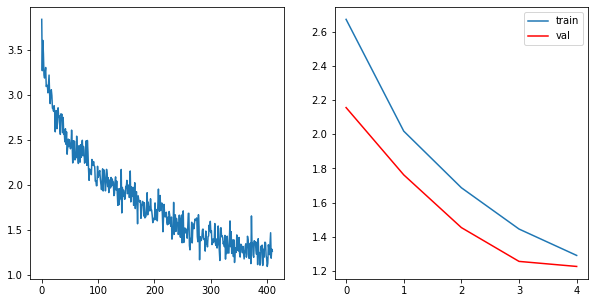

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(1.2678, grad_fn=<NllLossBackward0>)
tensor(1.0265, grad_fn=<NllLossBackward0>)
tensor(1.2745, grad_fn=<NllLossBackward0>)
tensor(1.1776, grad_fn=<NllLossBackward0>)
tensor(1.2702, grad_fn=<NllLossBackward0>)
tensor(1.1930, grad_fn=<NllLossBackward0>)
tensor(1.2191, grad_fn=<NllLossBackward0>)
tensor(1.2766, grad_fn=<NllLossBackward0>)
tensor(1.1740, grad_fn=<NllLossBackward0>)
tensor(1.1848, grad_fn=<NllLossBackward0>)
tensor(1.0992, grad_fn=<NllLossBackward0>)
tensor(1.1492, grad_fn=<NllLossBackward0>)
tensor(1.0010, grad_fn=<NllLossBackward0>)
tensor(1.2031, grad_fn=<NllLossBackward0>)
tensor(1.1232, grad_fn=<NllLossBackward0>)
tensor(1.2482, grad_fn=<NllLossBackward0>)
tensor(1.0898, grad_fn=<NllLossBackward0>)
tensor(1.1598, grad_fn=<NllLossBackward0>)
tensor(1.0668, grad_fn=<NllLossBackward0>)
tensor(1.2340, grad_fn=<NllLossBackward0>)
tensor(1.1858, grad_fn=<NllLossBackward0>)
tensor(1.1885, grad_fn=<NllLossBackward0>)
tensor(1.2195, grad_fn=<NllLossBackward0>)
tensor(1.08

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5	 \Training Loss: 1.14128280776303	     Validation Loss:0.9916793879340676	 \ LR:0.0001


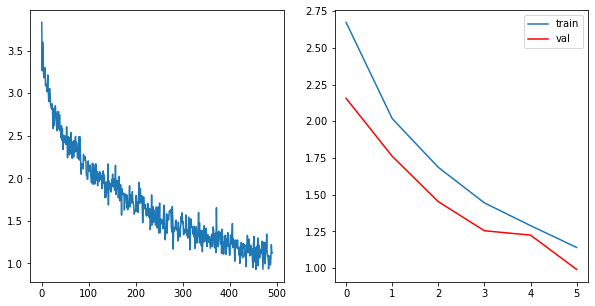

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(1.0930, grad_fn=<NllLossBackward0>)
tensor(1.0791, grad_fn=<NllLossBackward0>)
tensor(1.0277, grad_fn=<NllLossBackward0>)
tensor(0.9975, grad_fn=<NllLossBackward0>)
tensor(0.9480, grad_fn=<NllLossBackward0>)
tensor(1.0549, grad_fn=<NllLossBackward0>)
tensor(1.0563, grad_fn=<NllLossBackward0>)
tensor(1.0860, grad_fn=<NllLossBackward0>)
tensor(1.1589, grad_fn=<NllLossBackward0>)
tensor(1.0004, grad_fn=<NllLossBackward0>)
tensor(1.0651, grad_fn=<NllLossBackward0>)
tensor(1.0885, grad_fn=<NllLossBackward0>)
tensor(0.9689, grad_fn=<NllLossBackward0>)
tensor(0.9039, grad_fn=<NllLossBackward0>)
tensor(1.0423, grad_fn=<NllLossBackward0>)
tensor(1.0618, grad_fn=<NllLossBackward0>)
tensor(1.0594, grad_fn=<NllLossBackward0>)
tensor(1.0940, grad_fn=<NllLossBackward0>)
tensor(1.0411, grad_fn=<NllLossBackward0>)
tensor(1.0162, grad_fn=<NllLossBackward0>)
tensor(1.1062, grad_fn=<NllLossBackward0>)
tensor(1.0775, grad_fn=<NllLossBackward0>)
tensor(1.0286, grad_fn=<NllLossBackward0>)
tensor(1.13

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6	 \Training Loss: 1.0416468207429095	     Validation Loss:0.9229229232844185	 \ LR:0.0001


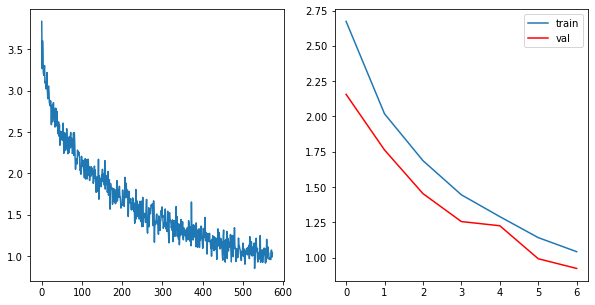

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.9185, grad_fn=<NllLossBackward0>)
tensor(0.9758, grad_fn=<NllLossBackward0>)
tensor(0.9303, grad_fn=<NllLossBackward0>)
tensor(1.0422, grad_fn=<NllLossBackward0>)
tensor(0.8788, grad_fn=<NllLossBackward0>)
tensor(0.9004, grad_fn=<NllLossBackward0>)
tensor(0.8921, grad_fn=<NllLossBackward0>)
tensor(0.8002, grad_fn=<NllLossBackward0>)
tensor(1.0599, grad_fn=<NllLossBackward0>)
tensor(1.1102, grad_fn=<NllLossBackward0>)
tensor(1.0752, grad_fn=<NllLossBackward0>)
tensor(0.8798, grad_fn=<NllLossBackward0>)
tensor(0.9045, grad_fn=<NllLossBackward0>)
tensor(0.9708, grad_fn=<NllLossBackward0>)
tensor(0.9591, grad_fn=<NllLossBackward0>)
tensor(1.0166, grad_fn=<NllLossBackward0>)
tensor(0.9186, grad_fn=<NllLossBackward0>)
tensor(0.6797, grad_fn=<NllLossBackward0>)
tensor(1.1621, grad_fn=<NllLossBackward0>)
tensor(0.8939, grad_fn=<NllLossBackward0>)
tensor(1.0369, grad_fn=<NllLossBackward0>)
tensor(1.1476, grad_fn=<NllLossBackward0>)
tensor(0.9812, grad_fn=<NllLossBackward0>)
tensor(0.93

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7	 \Training Loss: 0.9653084808733405	     Validation Loss:0.8734149021260879	 \ LR:0.0001


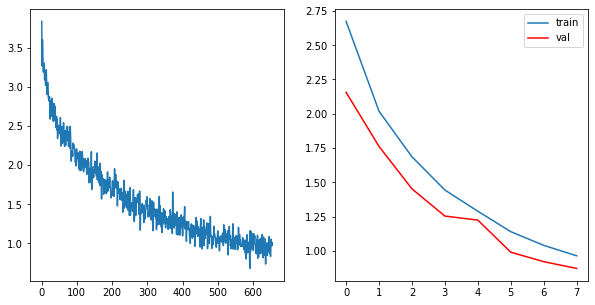

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(1.0505, grad_fn=<NllLossBackward0>)
tensor(0.8641, grad_fn=<NllLossBackward0>)
tensor(0.8173, grad_fn=<NllLossBackward0>)
tensor(0.8851, grad_fn=<NllLossBackward0>)
tensor(1.1181, grad_fn=<NllLossBackward0>)
tensor(0.8431, grad_fn=<NllLossBackward0>)
tensor(0.9497, grad_fn=<NllLossBackward0>)
tensor(0.9781, grad_fn=<NllLossBackward0>)
tensor(0.8678, grad_fn=<NllLossBackward0>)
tensor(0.8785, grad_fn=<NllLossBackward0>)
tensor(0.9422, grad_fn=<NllLossBackward0>)
tensor(0.9953, grad_fn=<NllLossBackward0>)
tensor(0.8553, grad_fn=<NllLossBackward0>)
tensor(0.9526, grad_fn=<NllLossBackward0>)
tensor(0.8764, grad_fn=<NllLossBackward0>)
tensor(0.9322, grad_fn=<NllLossBackward0>)
tensor(0.9053, grad_fn=<NllLossBackward0>)
tensor(0.8285, grad_fn=<NllLossBackward0>)
tensor(0.9001, grad_fn=<NllLossBackward0>)
tensor(0.9196, grad_fn=<NllLossBackward0>)
tensor(0.9463, grad_fn=<NllLossBackward0>)
tensor(0.8243, grad_fn=<NllLossBackward0>)
tensor(0.8457, grad_fn=<NllLossBackward0>)
tensor(0.91

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8	 \Training Loss: 0.9013043162299366	     Validation Loss:0.7885060660979327	 \ LR:0.0001


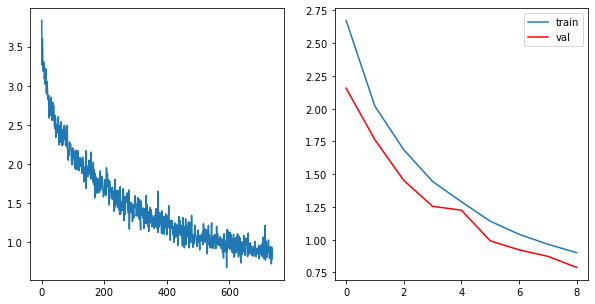

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.8622, grad_fn=<NllLossBackward0>)
tensor(0.7848, grad_fn=<NllLossBackward0>)
tensor(0.8296, grad_fn=<NllLossBackward0>)
tensor(0.8955, grad_fn=<NllLossBackward0>)
tensor(0.7005, grad_fn=<NllLossBackward0>)
tensor(0.9714, grad_fn=<NllLossBackward0>)
tensor(0.9421, grad_fn=<NllLossBackward0>)
tensor(1.0912, grad_fn=<NllLossBackward0>)
tensor(0.9365, grad_fn=<NllLossBackward0>)
tensor(0.9430, grad_fn=<NllLossBackward0>)
tensor(0.7973, grad_fn=<NllLossBackward0>)
tensor(0.9383, grad_fn=<NllLossBackward0>)
tensor(0.7299, grad_fn=<NllLossBackward0>)
tensor(0.7662, grad_fn=<NllLossBackward0>)
tensor(0.9304, grad_fn=<NllLossBackward0>)
tensor(0.8191, grad_fn=<NllLossBackward0>)
tensor(0.8793, grad_fn=<NllLossBackward0>)
tensor(0.8718, grad_fn=<NllLossBackward0>)
tensor(0.9000, grad_fn=<NllLossBackward0>)
tensor(0.8606, grad_fn=<NllLossBackward0>)
tensor(0.9357, grad_fn=<NllLossBackward0>)
tensor(0.7971, grad_fn=<NllLossBackward0>)
tensor(0.8008, grad_fn=<NllLossBackward0>)
tensor(0.84

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9	 \Training Loss: 0.8479260438826026	     Validation Loss:0.8029870986938477	 \ LR:0.0001


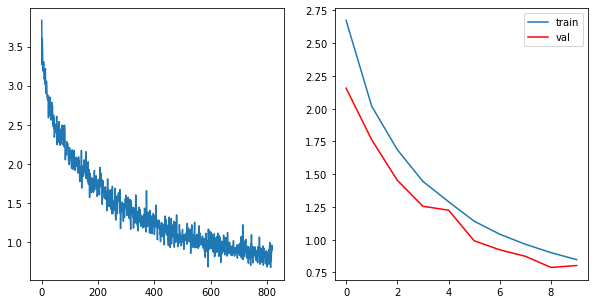

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.8815, grad_fn=<NllLossBackward0>)
tensor(0.7546, grad_fn=<NllLossBackward0>)
tensor(0.9286, grad_fn=<NllLossBackward0>)
tensor(0.9922, grad_fn=<NllLossBackward0>)
tensor(0.9308, grad_fn=<NllLossBackward0>)
tensor(0.7857, grad_fn=<NllLossBackward0>)
tensor(0.6690, grad_fn=<NllLossBackward0>)
tensor(0.8996, grad_fn=<NllLossBackward0>)
tensor(0.7361, grad_fn=<NllLossBackward0>)
tensor(0.6821, grad_fn=<NllLossBackward0>)
tensor(0.8455, grad_fn=<NllLossBackward0>)
tensor(0.8408, grad_fn=<NllLossBackward0>)
tensor(0.7162, grad_fn=<NllLossBackward0>)
tensor(0.8494, grad_fn=<NllLossBackward0>)
tensor(0.7360, grad_fn=<NllLossBackward0>)
tensor(0.8169, grad_fn=<NllLossBackward0>)
tensor(0.7373, grad_fn=<NllLossBackward0>)
tensor(0.7837, grad_fn=<NllLossBackward0>)
tensor(0.8343, grad_fn=<NllLossBackward0>)
tensor(0.9752, grad_fn=<NllLossBackward0>)
tensor(0.7443, grad_fn=<NllLossBackward0>)
tensor(0.7088, grad_fn=<NllLossBackward0>)
tensor(0.8718, grad_fn=<NllLossBackward0>)
tensor(0.74

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10	 \Training Loss: 0.7925058639631039	     Validation Loss:0.75451178410474	 \ LR:0.0001


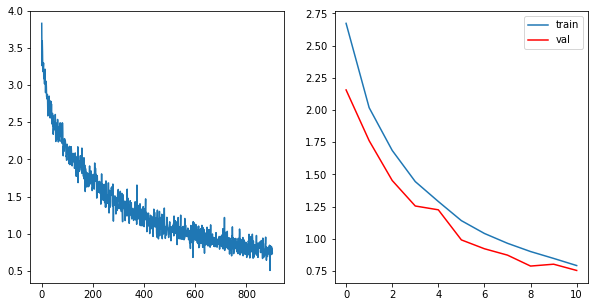

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.6864, grad_fn=<NllLossBackward0>)
tensor(0.7971, grad_fn=<NllLossBackward0>)
tensor(0.7179, grad_fn=<NllLossBackward0>)
tensor(0.8134, grad_fn=<NllLossBackward0>)
tensor(0.7384, grad_fn=<NllLossBackward0>)
tensor(0.8026, grad_fn=<NllLossBackward0>)
tensor(0.7146, grad_fn=<NllLossBackward0>)
tensor(0.8187, grad_fn=<NllLossBackward0>)
tensor(0.7168, grad_fn=<NllLossBackward0>)
tensor(0.7500, grad_fn=<NllLossBackward0>)
tensor(0.6028, grad_fn=<NllLossBackward0>)
tensor(0.8413, grad_fn=<NllLossBackward0>)
tensor(0.6016, grad_fn=<NllLossBackward0>)
tensor(0.9614, grad_fn=<NllLossBackward0>)
tensor(0.8230, grad_fn=<NllLossBackward0>)
tensor(0.7075, grad_fn=<NllLossBackward0>)
tensor(0.7814, grad_fn=<NllLossBackward0>)
tensor(0.7361, grad_fn=<NllLossBackward0>)
tensor(0.6428, grad_fn=<NllLossBackward0>)
tensor(0.6931, grad_fn=<NllLossBackward0>)
tensor(0.7582, grad_fn=<NllLossBackward0>)
tensor(0.8001, grad_fn=<NllLossBackward0>)
tensor(0.6858, grad_fn=<NllLossBackward0>)
tensor(0.80

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11	 \Training Loss: 0.7375784901584067	     Validation Loss:0.6804729910457835	 \ LR:0.0001


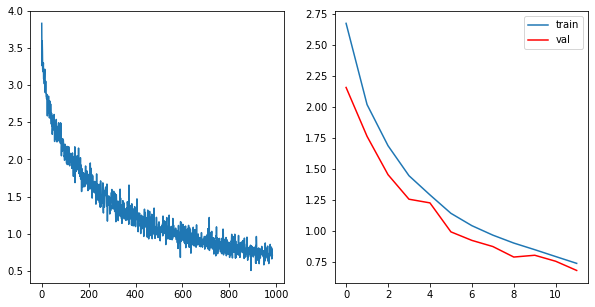

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.7075, grad_fn=<NllLossBackward0>)
tensor(0.7785, grad_fn=<NllLossBackward0>)
tensor(0.5878, grad_fn=<NllLossBackward0>)
tensor(0.7198, grad_fn=<NllLossBackward0>)
tensor(0.5896, grad_fn=<NllLossBackward0>)
tensor(0.6502, grad_fn=<NllLossBackward0>)
tensor(0.7011, grad_fn=<NllLossBackward0>)
tensor(0.5502, grad_fn=<NllLossBackward0>)
tensor(0.7574, grad_fn=<NllLossBackward0>)
tensor(0.9027, grad_fn=<NllLossBackward0>)
tensor(0.6683, grad_fn=<NllLossBackward0>)
tensor(0.7003, grad_fn=<NllLossBackward0>)
tensor(0.7942, grad_fn=<NllLossBackward0>)
tensor(0.7637, grad_fn=<NllLossBackward0>)
tensor(0.5750, grad_fn=<NllLossBackward0>)
tensor(0.5962, grad_fn=<NllLossBackward0>)
tensor(0.7350, grad_fn=<NllLossBackward0>)
tensor(0.5807, grad_fn=<NllLossBackward0>)
tensor(0.7308, grad_fn=<NllLossBackward0>)
tensor(0.6962, grad_fn=<NllLossBackward0>)
tensor(0.7768, grad_fn=<NllLossBackward0>)
tensor(0.7545, grad_fn=<NllLossBackward0>)
tensor(0.6835, grad_fn=<NllLossBackward0>)
tensor(0.75

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12	 \Training Loss: 0.6969331524721006	     Validation Loss:0.6229489235317006	 \ LR:0.0001


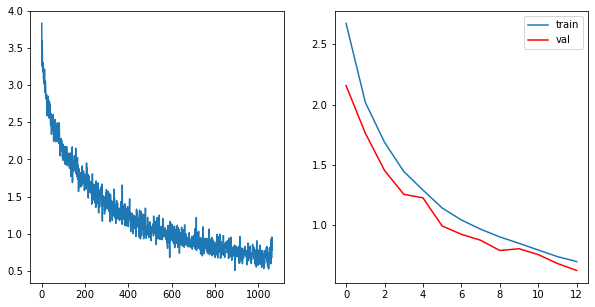

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5459, grad_fn=<NllLossBackward0>)
tensor(0.7247, grad_fn=<NllLossBackward0>)
tensor(0.6942, grad_fn=<NllLossBackward0>)
tensor(0.6799, grad_fn=<NllLossBackward0>)
tensor(0.7085, grad_fn=<NllLossBackward0>)
tensor(0.5970, grad_fn=<NllLossBackward0>)
tensor(0.6779, grad_fn=<NllLossBackward0>)
tensor(0.7025, grad_fn=<NllLossBackward0>)
tensor(0.7628, grad_fn=<NllLossBackward0>)
tensor(0.5182, grad_fn=<NllLossBackward0>)
tensor(0.6087, grad_fn=<NllLossBackward0>)
tensor(0.7137, grad_fn=<NllLossBackward0>)
tensor(0.5798, grad_fn=<NllLossBackward0>)
tensor(0.5494, grad_fn=<NllLossBackward0>)
tensor(0.7723, grad_fn=<NllLossBackward0>)
tensor(0.6825, grad_fn=<NllLossBackward0>)
tensor(0.6442, grad_fn=<NllLossBackward0>)
tensor(0.7219, grad_fn=<NllLossBackward0>)
tensor(0.6627, grad_fn=<NllLossBackward0>)
tensor(0.7156, grad_fn=<NllLossBackward0>)
tensor(0.5560, grad_fn=<NllLossBackward0>)
tensor(0.6316, grad_fn=<NllLossBackward0>)
tensor(0.6881, grad_fn=<NllLossBackward0>)
tensor(0.65

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13	 \Training Loss: 0.6716162504219427	     Validation Loss:0.5905848548692816	 \ LR:0.0001


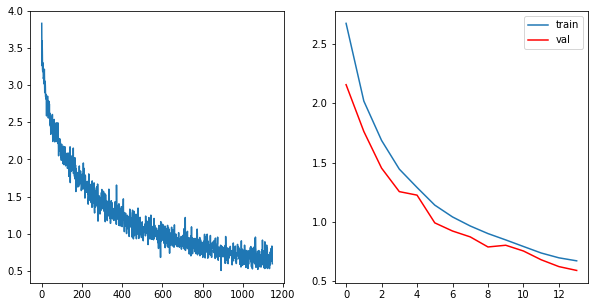

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5528, grad_fn=<NllLossBackward0>)
tensor(0.5560, grad_fn=<NllLossBackward0>)
tensor(0.6482, grad_fn=<NllLossBackward0>)
tensor(0.7014, grad_fn=<NllLossBackward0>)
tensor(0.5635, grad_fn=<NllLossBackward0>)
tensor(0.5300, grad_fn=<NllLossBackward0>)
tensor(0.6997, grad_fn=<NllLossBackward0>)
tensor(0.6223, grad_fn=<NllLossBackward0>)
tensor(0.7115, grad_fn=<NllLossBackward0>)
tensor(0.4779, grad_fn=<NllLossBackward0>)
tensor(0.5719, grad_fn=<NllLossBackward0>)
tensor(0.5740, grad_fn=<NllLossBackward0>)
tensor(0.4946, grad_fn=<NllLossBackward0>)
tensor(0.6677, grad_fn=<NllLossBackward0>)
tensor(0.5748, grad_fn=<NllLossBackward0>)
tensor(0.6403, grad_fn=<NllLossBackward0>)
tensor(0.5841, grad_fn=<NllLossBackward0>)
tensor(0.5941, grad_fn=<NllLossBackward0>)
tensor(0.5456, grad_fn=<NllLossBackward0>)
tensor(0.5788, grad_fn=<NllLossBackward0>)
tensor(0.6535, grad_fn=<NllLossBackward0>)
tensor(0.5625, grad_fn=<NllLossBackward0>)
tensor(0.6923, grad_fn=<NllLossBackward0>)
tensor(0.58

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14	 \Training Loss: 0.6407543827847737	     Validation Loss:0.601124156923855	 \ LR:0.0001


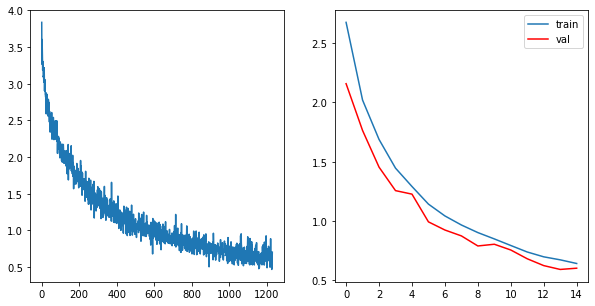

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5716, grad_fn=<NllLossBackward0>)
tensor(0.7249, grad_fn=<NllLossBackward0>)
tensor(0.5298, grad_fn=<NllLossBackward0>)
tensor(0.5158, grad_fn=<NllLossBackward0>)
tensor(0.5337, grad_fn=<NllLossBackward0>)
tensor(0.6426, grad_fn=<NllLossBackward0>)
tensor(0.6295, grad_fn=<NllLossBackward0>)
tensor(0.6966, grad_fn=<NllLossBackward0>)
tensor(0.6004, grad_fn=<NllLossBackward0>)
tensor(0.6437, grad_fn=<NllLossBackward0>)
tensor(0.5723, grad_fn=<NllLossBackward0>)
tensor(0.5857, grad_fn=<NllLossBackward0>)
tensor(0.7344, grad_fn=<NllLossBackward0>)
tensor(0.7213, grad_fn=<NllLossBackward0>)
tensor(0.5505, grad_fn=<NllLossBackward0>)
tensor(0.6065, grad_fn=<NllLossBackward0>)
tensor(0.4997, grad_fn=<NllLossBackward0>)
tensor(0.6783, grad_fn=<NllLossBackward0>)
tensor(0.6354, grad_fn=<NllLossBackward0>)
tensor(0.7033, grad_fn=<NllLossBackward0>)
tensor(0.6761, grad_fn=<NllLossBackward0>)
tensor(0.6002, grad_fn=<NllLossBackward0>)
tensor(0.5832, grad_fn=<NllLossBackward0>)
tensor(0.67

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15	 \Training Loss: 0.612723435207111	     Validation Loss:0.5471396148204803	 \ LR:0.0001


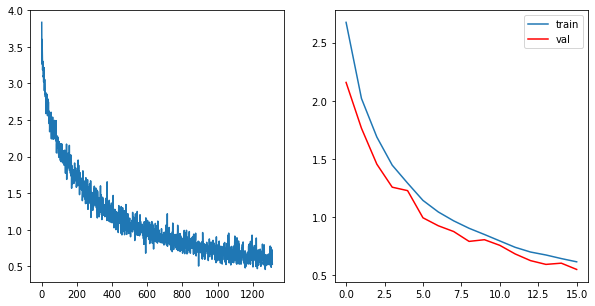

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5213, grad_fn=<NllLossBackward0>)
tensor(0.4973, grad_fn=<NllLossBackward0>)
tensor(0.5502, grad_fn=<NllLossBackward0>)
tensor(0.5973, grad_fn=<NllLossBackward0>)
tensor(0.6329, grad_fn=<NllLossBackward0>)
tensor(0.5234, grad_fn=<NllLossBackward0>)
tensor(0.5477, grad_fn=<NllLossBackward0>)
tensor(0.4815, grad_fn=<NllLossBackward0>)
tensor(0.5753, grad_fn=<NllLossBackward0>)
tensor(0.5674, grad_fn=<NllLossBackward0>)
tensor(0.6725, grad_fn=<NllLossBackward0>)
tensor(0.5204, grad_fn=<NllLossBackward0>)
tensor(0.5618, grad_fn=<NllLossBackward0>)
tensor(0.5321, grad_fn=<NllLossBackward0>)
tensor(0.5477, grad_fn=<NllLossBackward0>)
tensor(0.4837, grad_fn=<NllLossBackward0>)
tensor(0.5683, grad_fn=<NllLossBackward0>)
tensor(0.5780, grad_fn=<NllLossBackward0>)
tensor(0.7634, grad_fn=<NllLossBackward0>)
tensor(0.6672, grad_fn=<NllLossBackward0>)
tensor(0.4671, grad_fn=<NllLossBackward0>)
tensor(0.7556, grad_fn=<NllLossBackward0>)
tensor(0.5031, grad_fn=<NllLossBackward0>)
tensor(0.54

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16	 \Training Loss: 0.5830993459718984	     Validation Loss:0.552842527627945	 \ LR:0.0001


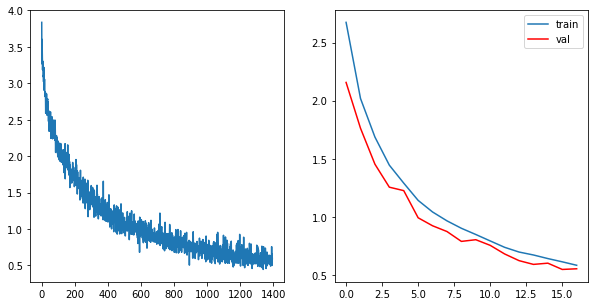

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.6034, grad_fn=<NllLossBackward0>)
tensor(0.5726, grad_fn=<NllLossBackward0>)
tensor(0.4633, grad_fn=<NllLossBackward0>)
tensor(0.6095, grad_fn=<NllLossBackward0>)
tensor(0.5331, grad_fn=<NllLossBackward0>)
tensor(0.5439, grad_fn=<NllLossBackward0>)
tensor(0.6238, grad_fn=<NllLossBackward0>)
tensor(0.4763, grad_fn=<NllLossBackward0>)
tensor(0.4444, grad_fn=<NllLossBackward0>)
tensor(0.5143, grad_fn=<NllLossBackward0>)
tensor(0.5531, grad_fn=<NllLossBackward0>)
tensor(0.6174, grad_fn=<NllLossBackward0>)
tensor(0.5668, grad_fn=<NllLossBackward0>)
tensor(0.6953, grad_fn=<NllLossBackward0>)
tensor(0.4514, grad_fn=<NllLossBackward0>)
tensor(0.6643, grad_fn=<NllLossBackward0>)
tensor(0.4351, grad_fn=<NllLossBackward0>)
tensor(0.6244, grad_fn=<NllLossBackward0>)
tensor(0.6392, grad_fn=<NllLossBackward0>)
tensor(0.5987, grad_fn=<NllLossBackward0>)
tensor(0.6953, grad_fn=<NllLossBackward0>)
tensor(0.5722, grad_fn=<NllLossBackward0>)
tensor(0.5510, grad_fn=<NllLossBackward0>)
tensor(0.56

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17	 \Training Loss: 0.5705721171163931	     Validation Loss:0.49840503405122194	 \ LR:0.0001


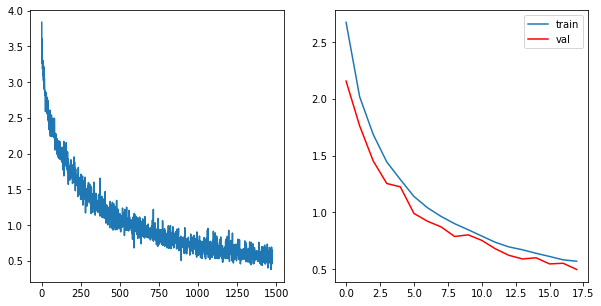

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5005, grad_fn=<NllLossBackward0>)
tensor(0.5340, grad_fn=<NllLossBackward0>)
tensor(0.4740, grad_fn=<NllLossBackward0>)
tensor(0.4125, grad_fn=<NllLossBackward0>)
tensor(0.5040, grad_fn=<NllLossBackward0>)
tensor(0.5492, grad_fn=<NllLossBackward0>)
tensor(0.4928, grad_fn=<NllLossBackward0>)
tensor(0.4899, grad_fn=<NllLossBackward0>)
tensor(0.4503, grad_fn=<NllLossBackward0>)
tensor(0.3789, grad_fn=<NllLossBackward0>)
tensor(0.4903, grad_fn=<NllLossBackward0>)
tensor(0.5846, grad_fn=<NllLossBackward0>)
tensor(0.5448, grad_fn=<NllLossBackward0>)
tensor(0.5037, grad_fn=<NllLossBackward0>)
tensor(0.4870, grad_fn=<NllLossBackward0>)
tensor(0.6622, grad_fn=<NllLossBackward0>)
tensor(0.5306, grad_fn=<NllLossBackward0>)
tensor(0.5615, grad_fn=<NllLossBackward0>)
tensor(0.5371, grad_fn=<NllLossBackward0>)
tensor(0.5131, grad_fn=<NllLossBackward0>)
tensor(0.5739, grad_fn=<NllLossBackward0>)
tensor(0.6576, grad_fn=<NllLossBackward0>)
tensor(0.5438, grad_fn=<NllLossBackward0>)
tensor(0.56

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18	 \Training Loss: 0.5296420898379349	     Validation Loss:0.4858258454238667	 \ LR:0.0001


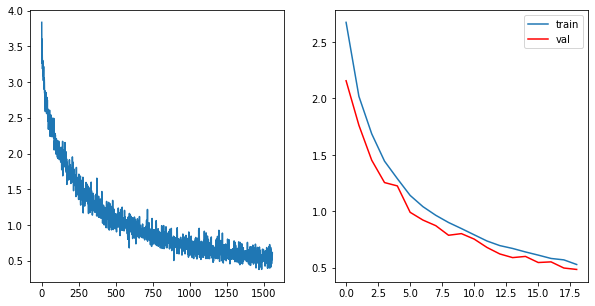

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.6194, grad_fn=<NllLossBackward0>)
tensor(0.4031, grad_fn=<NllLossBackward0>)
tensor(0.7188, grad_fn=<NllLossBackward0>)
tensor(0.4649, grad_fn=<NllLossBackward0>)
tensor(0.3685, grad_fn=<NllLossBackward0>)
tensor(0.4667, grad_fn=<NllLossBackward0>)
tensor(0.5146, grad_fn=<NllLossBackward0>)
tensor(0.6272, grad_fn=<NllLossBackward0>)
tensor(0.5071, grad_fn=<NllLossBackward0>)
tensor(0.5434, grad_fn=<NllLossBackward0>)
tensor(0.4559, grad_fn=<NllLossBackward0>)
tensor(0.4349, grad_fn=<NllLossBackward0>)
tensor(0.4508, grad_fn=<NllLossBackward0>)
tensor(0.4385, grad_fn=<NllLossBackward0>)
tensor(0.4909, grad_fn=<NllLossBackward0>)
tensor(0.4696, grad_fn=<NllLossBackward0>)
tensor(0.4885, grad_fn=<NllLossBackward0>)
tensor(0.5179, grad_fn=<NllLossBackward0>)
tensor(0.4336, grad_fn=<NllLossBackward0>)
tensor(0.5390, grad_fn=<NllLossBackward0>)
tensor(0.4729, grad_fn=<NllLossBackward0>)
tensor(0.5954, grad_fn=<NllLossBackward0>)
tensor(0.5448, grad_fn=<NllLossBackward0>)
tensor(0.46

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19	 \Training Loss: 0.5155230371690378	     Validation Loss:0.4370017244535334	 \ LR:0.0001


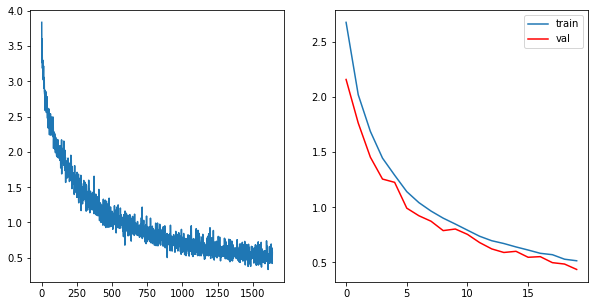

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5697, grad_fn=<NllLossBackward0>)
tensor(0.4190, grad_fn=<NllLossBackward0>)
tensor(0.5967, grad_fn=<NllLossBackward0>)
tensor(0.4048, grad_fn=<NllLossBackward0>)
tensor(0.4645, grad_fn=<NllLossBackward0>)
tensor(0.5007, grad_fn=<NllLossBackward0>)
tensor(0.4123, grad_fn=<NllLossBackward0>)
tensor(0.4929, grad_fn=<NllLossBackward0>)
tensor(0.3699, grad_fn=<NllLossBackward0>)
tensor(0.4846, grad_fn=<NllLossBackward0>)
tensor(0.4085, grad_fn=<NllLossBackward0>)
tensor(0.4476, grad_fn=<NllLossBackward0>)
tensor(0.5335, grad_fn=<NllLossBackward0>)
tensor(0.4618, grad_fn=<NllLossBackward0>)
tensor(0.4138, grad_fn=<NllLossBackward0>)
tensor(0.5270, grad_fn=<NllLossBackward0>)
tensor(0.4988, grad_fn=<NllLossBackward0>)
tensor(0.6097, grad_fn=<NllLossBackward0>)
tensor(0.4773, grad_fn=<NllLossBackward0>)
tensor(0.4988, grad_fn=<NllLossBackward0>)
tensor(0.5059, grad_fn=<NllLossBackward0>)
tensor(0.4839, grad_fn=<NllLossBackward0>)
tensor(0.4334, grad_fn=<NllLossBackward0>)
tensor(0.60

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20	 \Training Loss: 0.47949684756558114	     Validation Loss:0.45849784156855417	 \ LR:0.0001


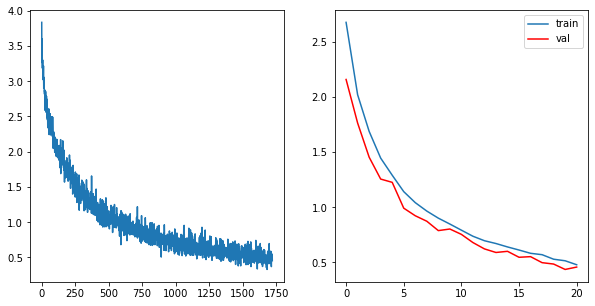

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5435, grad_fn=<NllLossBackward0>)
tensor(0.5185, grad_fn=<NllLossBackward0>)
tensor(0.4750, grad_fn=<NllLossBackward0>)
tensor(0.3910, grad_fn=<NllLossBackward0>)
tensor(0.4073, grad_fn=<NllLossBackward0>)
tensor(0.5089, grad_fn=<NllLossBackward0>)
tensor(0.5184, grad_fn=<NllLossBackward0>)
tensor(0.6107, grad_fn=<NllLossBackward0>)
tensor(0.5621, grad_fn=<NllLossBackward0>)
tensor(0.5461, grad_fn=<NllLossBackward0>)
tensor(0.3808, grad_fn=<NllLossBackward0>)
tensor(0.4089, grad_fn=<NllLossBackward0>)
tensor(0.5157, grad_fn=<NllLossBackward0>)
tensor(0.4468, grad_fn=<NllLossBackward0>)
tensor(0.5254, grad_fn=<NllLossBackward0>)
tensor(0.3998, grad_fn=<NllLossBackward0>)
tensor(0.4870, grad_fn=<NllLossBackward0>)
tensor(0.4169, grad_fn=<NllLossBackward0>)
tensor(0.3462, grad_fn=<NllLossBackward0>)
tensor(0.4225, grad_fn=<NllLossBackward0>)
tensor(0.5611, grad_fn=<NllLossBackward0>)
tensor(0.4381, grad_fn=<NllLossBackward0>)
tensor(0.5517, grad_fn=<NllLossBackward0>)
tensor(0.52

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21	 \Training Loss: 0.47403847153593853	     Validation Loss:0.43526432268759785	 \ LR:0.0001


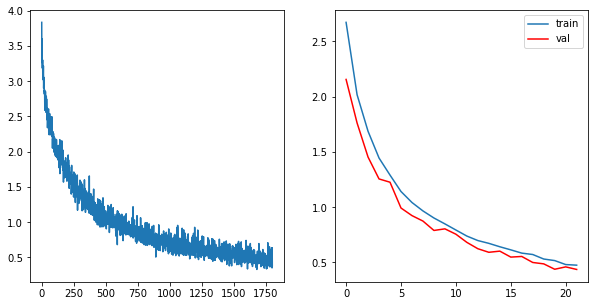

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5046, grad_fn=<NllLossBackward0>)
tensor(0.4889, grad_fn=<NllLossBackward0>)
tensor(0.4415, grad_fn=<NllLossBackward0>)
tensor(0.3233, grad_fn=<NllLossBackward0>)
tensor(0.4583, grad_fn=<NllLossBackward0>)
tensor(0.4628, grad_fn=<NllLossBackward0>)
tensor(0.3872, grad_fn=<NllLossBackward0>)
tensor(0.3767, grad_fn=<NllLossBackward0>)
tensor(0.5599, grad_fn=<NllLossBackward0>)
tensor(0.3442, grad_fn=<NllLossBackward0>)
tensor(0.3765, grad_fn=<NllLossBackward0>)
tensor(0.4328, grad_fn=<NllLossBackward0>)
tensor(0.4266, grad_fn=<NllLossBackward0>)
tensor(0.4516, grad_fn=<NllLossBackward0>)
tensor(0.3423, grad_fn=<NllLossBackward0>)
tensor(0.5833, grad_fn=<NllLossBackward0>)
tensor(0.3276, grad_fn=<NllLossBackward0>)
tensor(0.3743, grad_fn=<NllLossBackward0>)
tensor(0.3659, grad_fn=<NllLossBackward0>)
tensor(0.5166, grad_fn=<NllLossBackward0>)
tensor(0.3921, grad_fn=<NllLossBackward0>)
tensor(0.4204, grad_fn=<NllLossBackward0>)
tensor(0.4979, grad_fn=<NllLossBackward0>)
tensor(0.44

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22	 \Training Loss: 0.4559348654456255	     Validation Loss:0.4247739174786736	 \ LR:0.0001


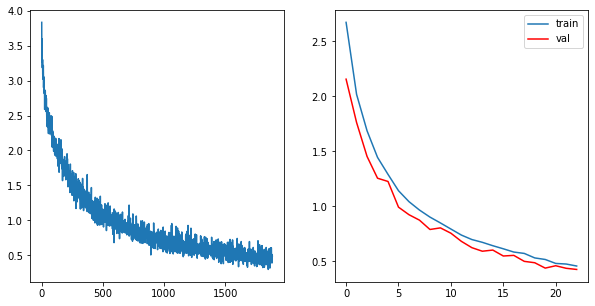

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.4791, grad_fn=<NllLossBackward0>)
tensor(0.4382, grad_fn=<NllLossBackward0>)
tensor(0.3740, grad_fn=<NllLossBackward0>)
tensor(0.4496, grad_fn=<NllLossBackward0>)
tensor(0.3096, grad_fn=<NllLossBackward0>)
tensor(0.4341, grad_fn=<NllLossBackward0>)
tensor(0.5497, grad_fn=<NllLossBackward0>)
tensor(0.3804, grad_fn=<NllLossBackward0>)
tensor(0.5085, grad_fn=<NllLossBackward0>)
tensor(0.4750, grad_fn=<NllLossBackward0>)
tensor(0.5168, grad_fn=<NllLossBackward0>)
tensor(0.3997, grad_fn=<NllLossBackward0>)
tensor(0.5050, grad_fn=<NllLossBackward0>)
tensor(0.4240, grad_fn=<NllLossBackward0>)
tensor(0.4832, grad_fn=<NllLossBackward0>)
tensor(0.4957, grad_fn=<NllLossBackward0>)
tensor(0.3714, grad_fn=<NllLossBackward0>)
tensor(0.4028, grad_fn=<NllLossBackward0>)
tensor(0.4054, grad_fn=<NllLossBackward0>)
tensor(0.4741, grad_fn=<NllLossBackward0>)
tensor(0.3903, grad_fn=<NllLossBackward0>)
tensor(0.6348, grad_fn=<NllLossBackward0>)
tensor(0.4671, grad_fn=<NllLossBackward0>)
tensor(0.36

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23	 \Training Loss: 0.44488278249414953	     Validation Loss:0.38579416625639973	 \ LR:0.0001


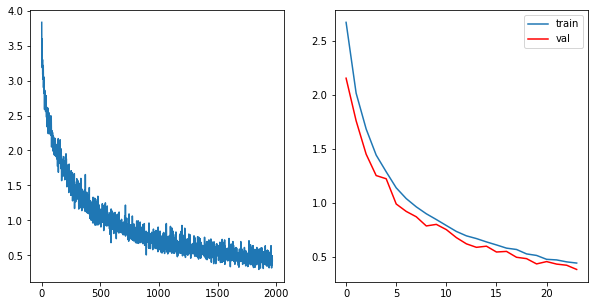

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.5116, grad_fn=<NllLossBackward0>)
tensor(0.4776, grad_fn=<NllLossBackward0>)
tensor(0.3875, grad_fn=<NllLossBackward0>)
tensor(0.5419, grad_fn=<NllLossBackward0>)
tensor(0.4988, grad_fn=<NllLossBackward0>)
tensor(0.3804, grad_fn=<NllLossBackward0>)
tensor(0.3744, grad_fn=<NllLossBackward0>)
tensor(0.4594, grad_fn=<NllLossBackward0>)
tensor(0.3838, grad_fn=<NllLossBackward0>)
tensor(0.5061, grad_fn=<NllLossBackward0>)
tensor(0.4529, grad_fn=<NllLossBackward0>)
tensor(0.2945, grad_fn=<NllLossBackward0>)
tensor(0.4964, grad_fn=<NllLossBackward0>)
tensor(0.5468, grad_fn=<NllLossBackward0>)
tensor(0.4373, grad_fn=<NllLossBackward0>)
tensor(0.3759, grad_fn=<NllLossBackward0>)
tensor(0.4505, grad_fn=<NllLossBackward0>)
tensor(0.4212, grad_fn=<NllLossBackward0>)
tensor(0.4716, grad_fn=<NllLossBackward0>)
tensor(0.3716, grad_fn=<NllLossBackward0>)
tensor(0.4024, grad_fn=<NllLossBackward0>)
tensor(0.4269, grad_fn=<NllLossBackward0>)
tensor(0.5754, grad_fn=<NllLossBackward0>)
tensor(0.37

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24	 \Training Loss: 0.4293988059933593	     Validation Loss:0.3626198330346276	 \ LR:0.0001


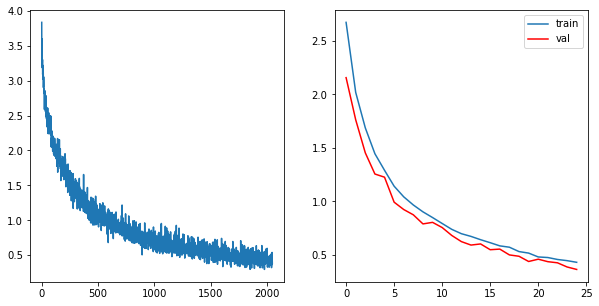

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.3378, grad_fn=<NllLossBackward0>)
tensor(0.3167, grad_fn=<NllLossBackward0>)
tensor(0.4637, grad_fn=<NllLossBackward0>)
tensor(0.3227, grad_fn=<NllLossBackward0>)
tensor(0.5007, grad_fn=<NllLossBackward0>)
tensor(0.2456, grad_fn=<NllLossBackward0>)
tensor(0.4277, grad_fn=<NllLossBackward0>)
tensor(0.5583, grad_fn=<NllLossBackward0>)
tensor(0.4023, grad_fn=<NllLossBackward0>)
tensor(0.4262, grad_fn=<NllLossBackward0>)
tensor(0.4884, grad_fn=<NllLossBackward0>)
tensor(0.3718, grad_fn=<NllLossBackward0>)
tensor(0.4998, grad_fn=<NllLossBackward0>)
tensor(0.5501, grad_fn=<NllLossBackward0>)
tensor(0.2653, grad_fn=<NllLossBackward0>)
tensor(0.4193, grad_fn=<NllLossBackward0>)
tensor(0.4688, grad_fn=<NllLossBackward0>)
tensor(0.4638, grad_fn=<NllLossBackward0>)
tensor(0.4283, grad_fn=<NllLossBackward0>)
tensor(0.5304, grad_fn=<NllLossBackward0>)
tensor(0.5530, grad_fn=<NllLossBackward0>)
tensor(0.4669, grad_fn=<NllLossBackward0>)
tensor(0.3827, grad_fn=<NllLossBackward0>)
tensor(0.50

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25	 \Training Loss: 0.4223322504904212	     Validation Loss:0.3674187432317173	 \ LR:0.0001


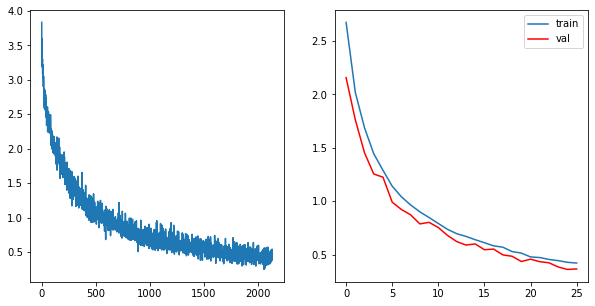

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.3329, grad_fn=<NllLossBackward0>)
tensor(0.3109, grad_fn=<NllLossBackward0>)
tensor(0.3449, grad_fn=<NllLossBackward0>)
tensor(0.4787, grad_fn=<NllLossBackward0>)
tensor(0.4457, grad_fn=<NllLossBackward0>)
tensor(0.3380, grad_fn=<NllLossBackward0>)
tensor(0.3730, grad_fn=<NllLossBackward0>)
tensor(0.3734, grad_fn=<NllLossBackward0>)
tensor(0.3354, grad_fn=<NllLossBackward0>)
tensor(0.4326, grad_fn=<NllLossBackward0>)
tensor(0.3113, grad_fn=<NllLossBackward0>)
tensor(0.4096, grad_fn=<NllLossBackward0>)
tensor(0.3170, grad_fn=<NllLossBackward0>)
tensor(0.3707, grad_fn=<NllLossBackward0>)
tensor(0.3999, grad_fn=<NllLossBackward0>)
tensor(0.3963, grad_fn=<NllLossBackward0>)
tensor(0.3441, grad_fn=<NllLossBackward0>)
tensor(0.3700, grad_fn=<NllLossBackward0>)
tensor(0.3604, grad_fn=<NllLossBackward0>)
tensor(0.3737, grad_fn=<NllLossBackward0>)
tensor(0.3491, grad_fn=<NllLossBackward0>)
tensor(0.4012, grad_fn=<NllLossBackward0>)
tensor(0.3403, grad_fn=<NllLossBackward0>)
tensor(0.32

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 26	 \Training Loss: 0.39137902964905996	     Validation Loss:0.3591483656097861	 \ LR:0.0001


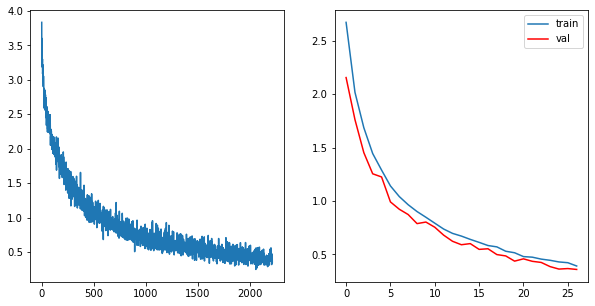

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.4325, grad_fn=<NllLossBackward0>)
tensor(0.3232, grad_fn=<NllLossBackward0>)
tensor(0.2865, grad_fn=<NllLossBackward0>)
tensor(0.2278, grad_fn=<NllLossBackward0>)
tensor(0.3121, grad_fn=<NllLossBackward0>)
tensor(0.3436, grad_fn=<NllLossBackward0>)
tensor(0.2940, grad_fn=<NllLossBackward0>)
tensor(0.2492, grad_fn=<NllLossBackward0>)
tensor(0.3710, grad_fn=<NllLossBackward0>)
tensor(0.3331, grad_fn=<NllLossBackward0>)
tensor(0.3481, grad_fn=<NllLossBackward0>)
tensor(0.3457, grad_fn=<NllLossBackward0>)
tensor(0.3671, grad_fn=<NllLossBackward0>)
tensor(0.3298, grad_fn=<NllLossBackward0>)
tensor(0.3711, grad_fn=<NllLossBackward0>)
tensor(0.3491, grad_fn=<NllLossBackward0>)
tensor(0.2465, grad_fn=<NllLossBackward0>)
tensor(0.3190, grad_fn=<NllLossBackward0>)
tensor(0.3547, grad_fn=<NllLossBackward0>)
tensor(0.3236, grad_fn=<NllLossBackward0>)
tensor(0.3373, grad_fn=<NllLossBackward0>)
tensor(0.4245, grad_fn=<NllLossBackward0>)
tensor(0.4219, grad_fn=<NllLossBackward0>)
tensor(0.39

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 27	 \Training Loss: 0.38326019811921	     Validation Loss:0.3509042105254005	 \ LR:0.0001


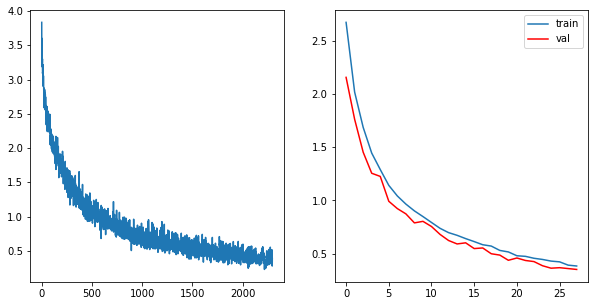

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.3352, grad_fn=<NllLossBackward0>)
tensor(0.3283, grad_fn=<NllLossBackward0>)
tensor(0.2740, grad_fn=<NllLossBackward0>)
tensor(0.3506, grad_fn=<NllLossBackward0>)
tensor(0.3301, grad_fn=<NllLossBackward0>)
tensor(0.3546, grad_fn=<NllLossBackward0>)
tensor(0.2813, grad_fn=<NllLossBackward0>)
tensor(0.3734, grad_fn=<NllLossBackward0>)
tensor(0.3631, grad_fn=<NllLossBackward0>)
tensor(0.4885, grad_fn=<NllLossBackward0>)
tensor(0.3426, grad_fn=<NllLossBackward0>)
tensor(0.3384, grad_fn=<NllLossBackward0>)
tensor(0.4400, grad_fn=<NllLossBackward0>)
tensor(0.2552, grad_fn=<NllLossBackward0>)
tensor(0.3861, grad_fn=<NllLossBackward0>)
tensor(0.2820, grad_fn=<NllLossBackward0>)
tensor(0.3667, grad_fn=<NllLossBackward0>)
tensor(0.3049, grad_fn=<NllLossBackward0>)
tensor(0.3224, grad_fn=<NllLossBackward0>)
tensor(0.3585, grad_fn=<NllLossBackward0>)
tensor(0.5190, grad_fn=<NllLossBackward0>)
tensor(0.3883, grad_fn=<NllLossBackward0>)
tensor(0.3351, grad_fn=<NllLossBackward0>)
tensor(0.56

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 28	 \Training Loss: 0.37270382355626036	     Validation Loss:0.30864611969274636	 \ LR:0.0001


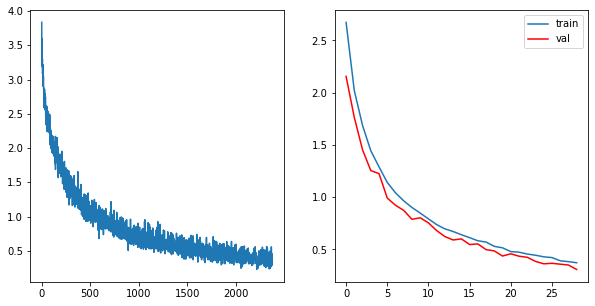

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.2837, grad_fn=<NllLossBackward0>)
tensor(0.3041, grad_fn=<NllLossBackward0>)
tensor(0.3868, grad_fn=<NllLossBackward0>)
tensor(0.3230, grad_fn=<NllLossBackward0>)
tensor(0.3196, grad_fn=<NllLossBackward0>)
tensor(0.4080, grad_fn=<NllLossBackward0>)
tensor(0.3288, grad_fn=<NllLossBackward0>)
tensor(0.3183, grad_fn=<NllLossBackward0>)
tensor(0.3245, grad_fn=<NllLossBackward0>)
tensor(0.3934, grad_fn=<NllLossBackward0>)
tensor(0.3106, grad_fn=<NllLossBackward0>)
tensor(0.3974, grad_fn=<NllLossBackward0>)
tensor(0.3937, grad_fn=<NllLossBackward0>)
tensor(0.3473, grad_fn=<NllLossBackward0>)
tensor(0.3452, grad_fn=<NllLossBackward0>)
tensor(0.4147, grad_fn=<NllLossBackward0>)
tensor(0.3352, grad_fn=<NllLossBackward0>)
tensor(0.3570, grad_fn=<NllLossBackward0>)
tensor(0.3804, grad_fn=<NllLossBackward0>)
tensor(0.4201, grad_fn=<NllLossBackward0>)
tensor(0.3952, grad_fn=<NllLossBackward0>)
tensor(0.3779, grad_fn=<NllLossBackward0>)
tensor(0.3756, grad_fn=<NllLossBackward0>)
tensor(0.34

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 29	 \Training Loss: 0.36868670073951165	     Validation Loss:0.3116287045619067	 \ LR:0.0001


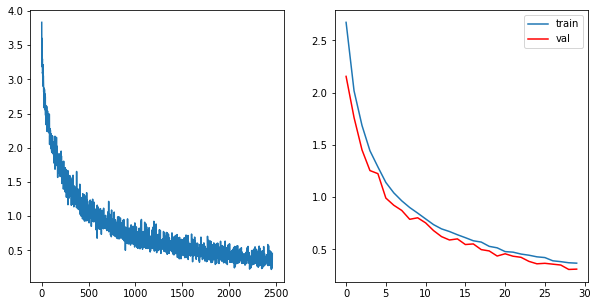

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.3879, grad_fn=<NllLossBackward0>)
tensor(0.3915, grad_fn=<NllLossBackward0>)
tensor(0.5050, grad_fn=<NllLossBackward0>)
tensor(0.2763, grad_fn=<NllLossBackward0>)
tensor(0.2710, grad_fn=<NllLossBackward0>)
tensor(0.3557, grad_fn=<NllLossBackward0>)
tensor(0.3542, grad_fn=<NllLossBackward0>)
tensor(0.4339, grad_fn=<NllLossBackward0>)
tensor(0.2638, grad_fn=<NllLossBackward0>)
tensor(0.3016, grad_fn=<NllLossBackward0>)
tensor(0.3775, grad_fn=<NllLossBackward0>)
tensor(0.3433, grad_fn=<NllLossBackward0>)
tensor(0.3086, grad_fn=<NllLossBackward0>)
tensor(0.4739, grad_fn=<NllLossBackward0>)
tensor(0.3556, grad_fn=<NllLossBackward0>)
tensor(0.3595, grad_fn=<NllLossBackward0>)
tensor(0.3166, grad_fn=<NllLossBackward0>)
tensor(0.3139, grad_fn=<NllLossBackward0>)
tensor(0.3447, grad_fn=<NllLossBackward0>)
tensor(0.3726, grad_fn=<NllLossBackward0>)
tensor(0.3729, grad_fn=<NllLossBackward0>)
tensor(0.3877, grad_fn=<NllLossBackward0>)
tensor(0.3259, grad_fn=<NllLossBackward0>)
tensor(0.47

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 30	 \Training Loss: 0.35526550288607434	     Validation Loss:0.28776545121389274	 \ LR:0.0001


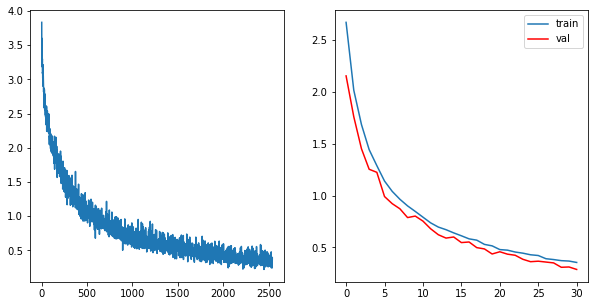

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.2801, grad_fn=<NllLossBackward0>)
tensor(0.2712, grad_fn=<NllLossBackward0>)
tensor(0.2616, grad_fn=<NllLossBackward0>)
tensor(0.3184, grad_fn=<NllLossBackward0>)
tensor(0.2545, grad_fn=<NllLossBackward0>)
tensor(0.3914, grad_fn=<NllLossBackward0>)
tensor(0.3516, grad_fn=<NllLossBackward0>)
tensor(0.2581, grad_fn=<NllLossBackward0>)
tensor(0.2754, grad_fn=<NllLossBackward0>)
tensor(0.3854, grad_fn=<NllLossBackward0>)
tensor(0.2789, grad_fn=<NllLossBackward0>)
tensor(0.2470, grad_fn=<NllLossBackward0>)
tensor(0.3954, grad_fn=<NllLossBackward0>)
tensor(0.3094, grad_fn=<NllLossBackward0>)
tensor(0.3787, grad_fn=<NllLossBackward0>)
tensor(0.2473, grad_fn=<NllLossBackward0>)
tensor(0.3787, grad_fn=<NllLossBackward0>)
tensor(0.4479, grad_fn=<NllLossBackward0>)
tensor(0.3221, grad_fn=<NllLossBackward0>)
tensor(0.2488, grad_fn=<NllLossBackward0>)
tensor(0.3890, grad_fn=<NllLossBackward0>)
tensor(0.3001, grad_fn=<NllLossBackward0>)
tensor(0.3280, grad_fn=<NllLossBackward0>)
tensor(0.33

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 31	 \Training Loss: 0.3460525617730327	     Validation Loss:0.32484761055778055	 \ LR:0.0001


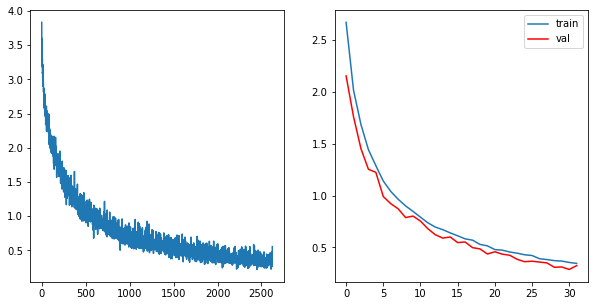

  0%|          | 0/82 [00:00<?, ?it/s]

tensor(0.2513, grad_fn=<NllLossBackward0>)
tensor(0.3598, grad_fn=<NllLossBackward0>)
tensor(0.3503, grad_fn=<NllLossBackward0>)
tensor(0.2766, grad_fn=<NllLossBackward0>)
tensor(0.2988, grad_fn=<NllLossBackward0>)
tensor(0.4471, grad_fn=<NllLossBackward0>)
tensor(0.3928, grad_fn=<NllLossBackward0>)
tensor(0.3814, grad_fn=<NllLossBackward0>)
tensor(0.2667, grad_fn=<NllLossBackward0>)
tensor(0.3966, grad_fn=<NllLossBackward0>)
tensor(0.3597, grad_fn=<NllLossBackward0>)
tensor(0.4016, grad_fn=<NllLossBackward0>)
tensor(0.3138, grad_fn=<NllLossBackward0>)
tensor(0.3174, grad_fn=<NllLossBackward0>)
tensor(0.3715, grad_fn=<NllLossBackward0>)
tensor(0.3289, grad_fn=<NllLossBackward0>)
tensor(0.3559, grad_fn=<NllLossBackward0>)
tensor(0.3720, grad_fn=<NllLossBackward0>)
tensor(0.3050, grad_fn=<NllLossBackward0>)
tensor(0.3883, grad_fn=<NllLossBackward0>)
tensor(0.3054, grad_fn=<NllLossBackward0>)
tensor(0.2665, grad_fn=<NllLossBackward0>)
tensor(0.2902, grad_fn=<NllLossBackward0>)
tensor(0.28

KeyboardInterrupt: 

In [20]:
from torch.autograd import Variable
from tqdm.notebook import tqdm
step_losses = []
epoch_losses_train = []
epoch_losses_val = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_loss_test = 0
    model.train()
    for X, Y in tqdm(data_loader_train, total=len(data_loader_train)):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        print(loss)
    if epoch % 5 == 0:
        state = {'info':  "baseline simpsons resnet+aug"+str(optimizer.param_groups[0]['lr']),            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
        torch.save(state, '/Simpsons_res_net_aug' + str(epoch)+ '.pth')
    with torch.no_grad():
        model.eval()
        for X, Y in tqdm(data_loader_val, total=len(data_loader_val), leave=False):
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)
            loss_test = criterion(Y_pred, Y)
            epoch_loss_test += loss_test.item()
    epoch_losses_val.append(epoch_loss_test/len(data_loader_val))
    epoch_losses_train.append(epoch_loss/len(data_loader_train))
    scheduler.step(epoch_loss_test/len(data_loader_val))
    curr_lr = optimizer.param_groups[0]['lr']
  
    print(f'Epoch {epoch}\t \Training Loss: {epoch_loss/len(data_loader_train)}\t \
    Validation Loss:{epoch_loss_test/len(data_loader_val)}\t \ LR:{curr_lr}')
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(step_losses)
    axes[1].plot(epoch_losses_train, label = 'train')
    axes[1].plot(epoch_losses_val, color = 'red', label = 'val')
    axes[1].legend()
    plt.show()


In [12]:
state = torch.load('/baseline simpsons_res_net20.pth', map_location=torch.device('cpu'))
model = Model(42).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(state['model'])        # получаем параметры модели
optimizer.load_state_dict(state['optimizer'])    # получаем состояние оптимизатора
 
print(state['info'], state['date'])

baseline simpsons resnet0.0001 2022-11-25 20:48:58.326857


In [13]:
optimizer.state_dict()

{'state': {0: {'step': 2751,
   'exp_avg': tensor([[[[-1.4403e-03, -1.0730e-03, -1.0538e-03],
             [-1.3668e-03, -1.0770e-03, -1.1696e-03],
             [-1.1408e-03, -8.6211e-04, -1.1011e-03]],
   
            [[-4.4607e-04, -1.3822e-04, -2.3011e-04],
             [-4.5538e-04, -1.6236e-04, -3.2125e-04],
             [-2.2300e-04,  7.1670e-05, -2.0856e-04]],
   
            [[ 2.9035e-03,  2.8876e-03,  2.8112e-03],
             [ 2.8512e-03,  2.7209e-03,  2.4982e-03],
             [ 2.7928e-03,  2.7029e-03,  2.2951e-03]]],
   
   
           [[[ 1.2318e-03,  9.7422e-04,  9.7323e-04],
             [ 1.2278e-03,  9.6094e-04,  8.9872e-04],
             [ 1.3552e-03,  1.1693e-03,  1.0655e-03]],
   
            [[ 9.1330e-04,  6.7250e-04,  6.0015e-04],
             [ 9.0281e-04,  6.5621e-04,  5.4291e-04],
             [ 1.0845e-03,  9.1624e-04,  8.1116e-04]],
   
            [[ 8.4744e-05, -1.2992e-04, -2.4676e-04],
             [ 5.9586e-05, -1.6240e-04, -3.2453e-04],
            

In [17]:
model.eval()

Model(
  (Relu): ReLU()
  (Sigmoid): Sigmoid()
  (contracting_11): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_11_res): Sequential(
    (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Batc

In [51]:
val_dataset = SimpsonsDataset(val_files, mode='val')
print(len(val_dataset))
data_loader_val = DataLoader(val_dataset, batch_size=128)
X, Y = iter(data_loader_train).next()
X, Y = X.to(device), Y.to(device)
print(X.shape, Y.shape)


4187
torch.Size([128, 3, 224, 224]) torch.Size([128])


In [52]:
with torch.no_grad():
        model.eval()
        Y_pred = model(X)
        Y_pred = nn.Softmax(dim = 1)(Y_pred)


In [53]:
Y_pred = Y_pred.argmax(dim = 1)

In [128]:
from sklearn.metrics import f1_score

f1_score(Y, Y_pred, average=None)

array([1.        , 1.        , 0.66666667, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.92307692, 1.        , 0.94117647, 1.        ,
       0.90909091, 0.94736842, 0.95652174, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [61]:
preds_class = [label_encoder.classes_[i] for i in Y_pred]
preds_class

['homer_simpson',
 'marge_simpson',
 'homer_simpson',
 'ned_flanders',
 'nelson_muntz',
 'edna_krabappel',
 'sideshow_bob',
 'homer_simpson',
 'principal_skinner',
 'lisa_simpson',
 'nelson_muntz',
 'lisa_simpson',
 'lenny_leonard',
 'bart_simpson',
 'edna_krabappel',
 'nelson_muntz',
 'chief_wiggum',
 'marge_simpson',
 'milhouse_van_houten',
 'marge_simpson',
 'abraham_grampa_simpson',
 'moe_szyslak',
 'comic_book_guy',
 'chief_wiggum',
 'milhouse_van_houten',
 'nelson_muntz',
 'chief_wiggum',
 'chief_wiggum',
 'bart_simpson',
 'moe_szyslak',
 'homer_simpson',
 'homer_simpson',
 'sideshow_bob',
 'martin_prince',
 'lisa_simpson',
 'chief_wiggum',
 'otto_mann',
 'chief_wiggum',
 'moe_szyslak',
 'ned_flanders',
 'sideshow_bob',
 'chief_wiggum',
 'charles_montgomery_burns',
 'lisa_simpson',
 'homer_simpson',
 'nelson_muntz',
 'chief_wiggum',
 'abraham_grampa_simpson',
 'edna_krabappel',
 'ned_flanders',
 'sideshow_bob',
 'apu_nahasapeemapetilon',
 'sideshow_bob',
 'abraham_grampa_simpson'

In [85]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [74]:
s=0
for i in range(42):
    s+=probs[3][i]
print(s)

1.0000000945179597


In [90]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [91]:
my_submit.to_csv('/simple_cnn_baseline.csv', index=False)

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [69]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs